In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1233)
tf.random.set_seed(1233)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

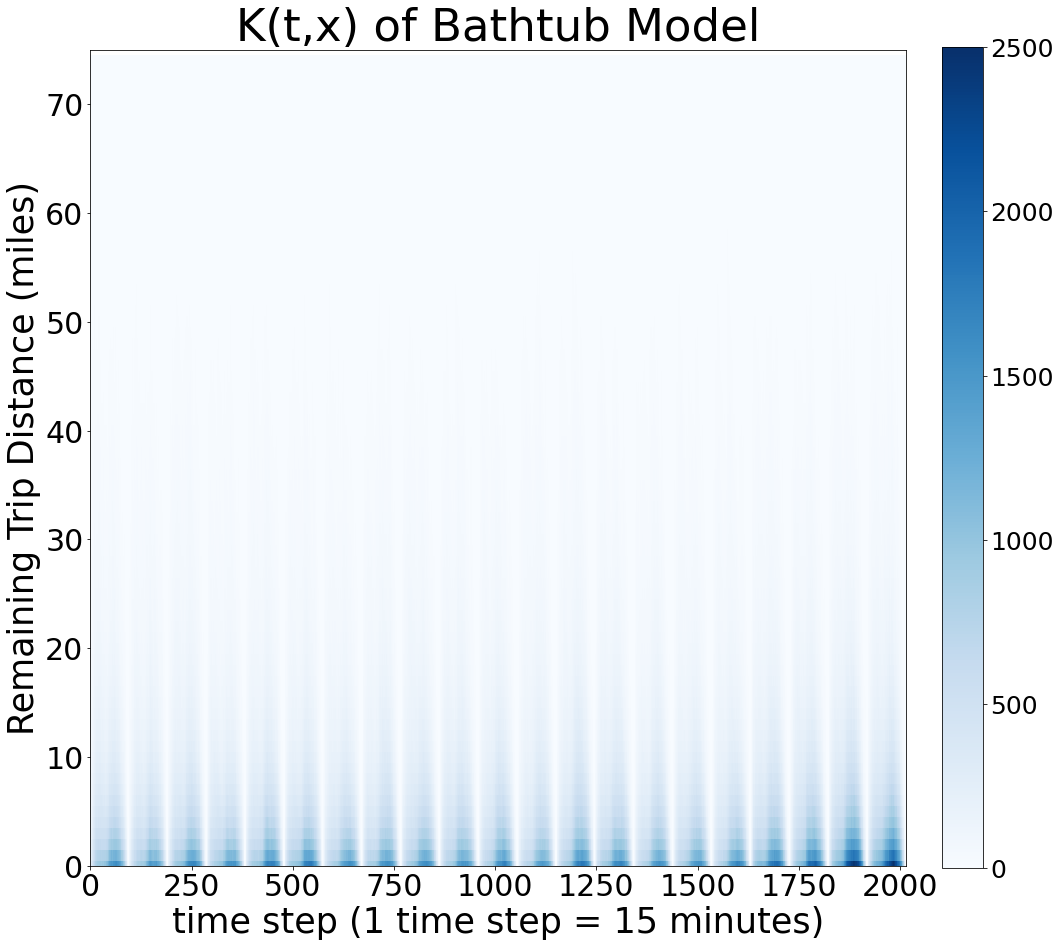

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 3 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  50400
N_u =  10080
N_f =  20160


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1233)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(10080, 2)

In [12]:
X_u_test.shape

(40320, 2)

In [13]:
X_u_train

array([[0.72972973, 0.75980149],
       [0.36486486, 0.27890819],
       [0.72972973, 0.93002481],
       ...,
       [0.32432432, 0.30918114],
       [0.2027027 , 0.23622829],
       [0.44594595, 0.30719603]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.0051973506341793946 0.0085415223907259318 0.0018531788776328579 0.8291044892013639
0.0046230707005419976 0.00830510732764077 0.00094103407344322512 0.8178550021051267
0.0040108517699374135 0.0077492122898016923 0.00027249125007313454 0.7909254719130433
0.0039545065287043676 0.0076079707936892917 0.00030104226371944283 0.7834344919373929
0.0037604308492043669 0.0071153492359004276 0.00040551246250830608 0.754841551791204
0.0037385172485361277 0.0071048758272319558 0.00037215866984029964 0.7537219631840059
0.0037317933664721614 0.0071028484746950794 0.00036073825824924338 0.7533746702859407
0.003722187007868714 0.00709683559266195 0.00034753842307547818 0.7528555384707831
0.0036957671963284968 0.0070723390963763283 0.00031919529628066491 0.7512289235037842
0.0036493358711246777 0.0070127612063863925 0.00028591053586296279 0.7477965027394184
0.0035749507383606035 0.0068841084929343417 0.00026579298378686533 0.7409322086869835
0.003461363114141934 0.0065992324025741676 0.0003234938257097

0.0025260184314996356 0.0043049845606047141 0.000747052302394557 0.5851499960295425
0.0025258799997810752 0.0043077637393777179 0.00074399626018443272 0.5853505300218453
0.0025255859407584654 0.0043129157048342279 0.00073825617668270282 0.5857331253480881
0.002524981901708617 0.0043188475130257632 0.00073111629039147061 0.5861993048908037
0.0025237945549660603 0.0043226616150713075 0.00072492749486081313 0.58654144629863
0.0025217235966445576 0.0043088799721194924 0.000734567221169623 0.5856179317428825
0.0025213451016988749 0.0042944515101153453 0.00074823869328240449 0.584634488226895
0.0025206910373330492 0.004283280143468406 0.0007581019311976927 0.5838146724729588
0.002520451132140793 0.0042913294535343594 0.00074957281074722641 0.5843818094176271
0.0025201092840671283 0.0042896681640030238 0.00075055040413123282 0.5842813023866238
0.0025197243698407423 0.004282517200787885 0.00075693153889359985 0.5838282053446462
0.0025193455075884362 0.0042890766286054023 0.00074961438657146983

0.00251226047717706 0.004279802988614116 0.000744717965740004 0.583711749100867
0.0025122265434304961 0.0042790848839108168 0.00074536820295017581 0.5836609635509244
0.0025121905599077617 0.0042788167282707939 0.00074556439154473 0.5836467873389881
0.0025121744586505813 0.0042794691559571059 0.00074487976134405686 0.583682200624877
0.002512125837802897 0.0042804334592387973 0.00074381821636699706 0.5837521339217605
0.002512061481808053 0.0042805096510036009 0.00074361331261250528 0.5837603262045412
0.0025119726201070502 0.0042791981583795323 0.00074474708183456867 0.5836742231019012
0.0025118997245664834 0.0042804608140171469 0.00074333863511582 0.5837668815361585
0.0025117262665452231 0.00427715357165021 0.00074629896144023586 0.5835821454597326
0.0025116890900016074 0.0042751311123842414 0.00074824706761897309 0.5834320298311678
0.0025115408013002358 0.0042725753140845377 0.00075050628851593387 0.5832450609512221
0.0025114258990279652 0.0042744869838057462 0.00074836481425018437 0.58

0.0024723877985323786 0.0042074901001691875 0.00073728549689556935 0.5785423993735176
0.0024723745832957822 0.004207401310110959 0.00073734785648060558 0.5785362780820348
0.002472352408131517 0.0042079656488217109 0.00073673916744132343 0.5785771200053191
0.0024722995302720887 0.0042078031859687781 0.00073679587457539924 0.5785659939386496
0.0024721874882588329 0.004208315865688237 0.000736059110829429 0.5786144677278403
0.0024720370572286227 0.00420707311643075 0.00073700099802649546 0.578530206883905
0.0024719800688963729 0.0042074440805349193 0.0007365160572578263 0.5786504198186798
0.0024718429780116332 0.0042081087344148062 0.00073557722160846027 0.5786259909594283
0.0024717963362118076 0.0042067971502008673 0.000736795522222748 0.5785479284874108
0.0024717507714817821 0.004207483183711583 0.00073601835925198131 0.5786059560503127
0.0024717412244651942 0.0042066120592004728 0.00073687038972991515 0.5785439050737107
0.0024717368710905252 0.0042061146225490257 0.00073735911963202492

0.0024514903065344009 0.0041781912230570315 0.00072478939001177026 0.576567901410485
0.0024514400208339167 0.0041762851497323568 0.00072659489193547633 0.5764196724450883
0.0024513238742631402 0.00417545893414049 0.00072718881438579093 0.5763367384554386
0.0024511706760311095 0.0041741706676820482 0.000728170684380171 0.5762054643545381
0.0024509345884974436 0.004174113830093632 0.00072775534690125551 0.5762026605854259
0.0024506107052361466 0.0041786872441960205 0.00072253416627627274 0.5764236512724128
0.0024503280619830288 0.0041750600652126196 0.000725596058753438 0.5763171872181906
0.002450064629597046 0.0041758838643759571 0.00072424539481813521 0.5763806620514395
0.002449940249783874 0.0041736953814549786 0.00072618511811276909 0.5762137380405092
0.0024498919783410697 0.0041729848036689624 0.000726799153013177 0.5761617817264236
0.0024497859001291174 0.004176021030474839 0.00072355076978339533 0.5763841306055274
0.0024497143238097572 0.0041774437657568714 0.00072198488186264265 

0.0024472938566777328 0.0041769345923231751 0.00071765312103229091 0.5765186058110581
0.002447288005137588 0.0041770904084170455 0.00071748560185813074 0.5765242924872724
0.0024472836423646421 0.0041765232397971272 0.00071804404493215732 0.5764887517098375
0.0024472783804269298 0.0041763713719644643 0.00071818538888939517 0.5764784245557416
0.0024472711528096547 0.0041762867963005554 0.00071825550931875416 0.5764761643205294
0.0024472544201586872 0.0041763463067131567 0.00071816253360421751 0.5764756372809433
0.002447239168273605 0.0041769982976746925 0.00071748003887251723 0.5765150326808518
0.0024472298517705339 0.004176762654454904 0.00071769704908616417 0.5764882898124111
0.0024472174943724542 0.0041753315821071316 0.00071910340663777664 0.5764091204042566
0.0024471987207069228 0.0041761009052362586 0.0007182965361775867 0.5764460439795371
0.00244719071707834 0.0041771436225200948 0.00071723781163658522 0.5765178852356116
0.0024471849576351394 0.0041762665877926727 0.00071810332747

0.0024447641847928575 0.0041772328854392284 0.000712295484146487 0.5766276116251295
0.0024447447958327664 0.0041767362575929595 0.000712753334072573 0.5765923733947053
0.0024447217060493717 0.0041771298371343383 0.00071231357496440541 0.5766211208112572
0.0024447082489679958 0.0041759632340097365 0.00071345326392625494 0.5765263909715349
0.0024446948949808089 0.0041754763050685659 0.00071391348489305165 0.5764980657111164
0.0024446873179150932 0.0041738684931228376 0.000715506142707349 0.5763805559439561
0.0024446767237454549 0.00417591536814058 0.0007134380793503292 0.5765173419509511
0.0024446675093991147 0.0041756398822512565 0.00071369513654697314 0.5764996823951284
0.002444649085077365 0.0041747536324722263 0.00071454453768250367 0.576440937434039
0.0024446123127587413 0.0041737905924282438 0.00071543403308923917 0.5763689811957903
0.0024445824072422584 0.0041731848892170012 0.00071597992526751576 0.5763120087787071
0.0024445403076684929 0.0041741819373984461 0.0007148986779385398

0.0024420648638942047 0.0041690566886464766 0.00071507303914193252 0.5760121057086872
0.0024420459512560534 0.0041698312247479448 0.00071426067776416237 0.5760901384440474
0.0024420176556977594 0.0041717989883358333 0.00071223632305968576 0.5762142384107997
0.00244197547731511 0.0041721608588134495 0.00071179009581677087 0.576234273234292
0.0024418193193089725 0.004175242126979898 0.00070839651163804673 0.5764221694001614
0.0024416674148112993 0.0041731544636208345 0.000710180366001764 0.5762639561592652
0.0024415130287344464 0.0041740395272762765 0.00070898653019261593 0.5763219546684119
0.0024414619447817964 0.0041730450555962336 0.0007098788339673592 0.5762236198716881
0.0024413865311157159 0.0041730315442564782 0.00070974151797495346 0.5762447676654561
0.0024413210241187892 0.0041696993964709991 0.000712942651766579 0.5760329934391439
0.0024412954172867364 0.0041699420039319453 0.00071264883064152764 0.5760465355772337
0.0024412662577795326 0.00417135134709527 0.0007111811684637951

0.0024386225461192693 0.0041702736648174454 0.000706971427421093 0.575970399739831
0.0024385977124913257 0.0041685548007677512 0.00070864062421490044 0.5758448646211136
0.0024385664149890766 0.0041703194138591184 0.00070681341611903521 0.5759493398450248
0.0024385520551762092 0.0041717592941801045 0.0007053448161723142 0.5760509477763675
0.0024385259459874381 0.0041709395075506268 0.00070611238442424987 0.5759937740921849
0.002438474865192621 0.0041708764463004927 0.00070607328408474964 0.5759871091988976
0.0024384300642462282 0.004169892274904107 0.00070696785358834993 0.5759149757686401
0.0024384179134327826 0.0041701963496159613 0.00070663947724960334 0.5759273925503697
0.0024383771604156424 0.0041734216202169456 0.00070333270061433942 0.5761628514962565
0.002438338260018773 0.0041709186046729428 0.00070575791536460356 0.5759715256266352
0.0024383091633073169 0.0041695328903269607 0.00070708543628767362 0.575893117655099
0.0024382306249274136 0.0041714174793221767 0.0007050437705326

0.0024332296303412534 0.0041634752379727958 0.00070298402270971142 0.5757336065945914
0.0024332013719418288 0.004164716254932403 0.00070168648895125414 0.5758106139837393
0.0024331690052959648 0.0041641379338254484 0.00070220007676648091 0.5757529618432307
0.0024331172651529771 0.0041655667673774505 0.00070066776292850355 0.5758551901435373
0.0024330871480711751 0.0041662628045872983 0.00069991149155505209 0.5759209445470083
0.0024330728128982545 0.0041669663983993866 0.00069917922739712269 0.5759620931330964
0.0024330586802764416 0.0041666780162466352 0.00069943934430624817 0.5759430576041328
0.0024330371887684517 0.0041651323878730256 0.00070094198966387761 0.5758349353465918
0.0024330159858749166 0.0041647849964374555 0.000701246975312378 0.5758081240557502
0.0024329859714417265 0.0041634667108813479 0.00070250523200210467 0.5757164343737348
0.0024329708540438534 0.0041651213857228963 0.00070082032236481052 0.5758124871238031
0.0024329567770820654 0.0041646479322702979 0.00070126562

0.0024312339325078553 0.0041636798481814452 0.00069878801683426542 0.5758807736213106
0.00243121751083638 0.0041641424385093564 0.00069829258316340341 0.5759122420233241
0.0024311946188767 0.0041643277240230947 0.00069806151373030519 0.5759273267264333
0.0024311739794535881 0.0041639253743975509 0.00069842258450962546 0.5758949466647043
0.0024311608541715828 0.004164481847300114 0.00069783986104305132 0.5759320668207528
0.0024311534422018252 0.0041635917221634492 0.00069871516224020145 0.5758801023529205
0.0024311433569167455 0.004163049432509682 0.00069923728132380942 0.575839413731994
0.0024311307143908834 0.0041631135381822908 0.00069914789059947633 0.5758440510023359
0.0024311147407510012 0.0041629016311221729 0.00069932785037982983 0.5758314268958109
0.0024310997316905479 0.0041640428921388669 0.00069815657124222932 0.5758902321404673
0.0024310599559742591 0.0041636782995807782 0.00069844161236774012 0.5758957093872857
0.0024310471761980561 0.004165771689131648 0.00069632266326446

0.0024281008688239974 0.00415398237654749 0.000702219361100505 0.575243145094973
0.0024279952513848826 0.0041558732373789724 0.0007001172653907931 0.5753525667809056
0.0024279827931137123 0.0041574422462586956 0.000698523339968729 0.5754684156308505
0.0024279273699964296 0.0041556109073189922 0.00070024383267386673 0.5753285165241664
0.0024279135888557618 0.0041551510549771567 0.00070067612273436663 0.575304870591844
0.0024279069170069505 0.0041567423261254718 0.00069907150788842912 0.5754130431684966
0.0024278965703532743 0.0041564056188639845 0.00069938752184256427 0.5753785295701314
0.0024278889549486002 0.0041558181990985973 0.00069995971079860313 0.5753429425292407
0.0024278794312335575 0.00415596161278254 0.00069979724968457536 0.5753503345836644
0.0024278746918683469 0.0041568153777870789 0.00069893400594961473 0.5754052629881822
0.0024278720287922309 0.0041567663044874033 0.00069897775309705817 0.5754030148588488
0.0024278693837474137 0.004156808102848907 0.0006989306646459205 

0.0024255120730146363 0.00415231490925329 0.00069870923677598266 0.5750940880041508
0.0024255052586499189 0.0041528492281087985 0.000698161289191039 0.5751367473583994
0.0024254932382967095 0.0041535797298714308 0.00069740674672198841 0.5751940052174515
0.0024254848475615039 0.004153547943982594 0.00069742175114041358 0.575197678144807
0.0024254771902080937 0.0041536024089337559 0.00069735197148243174 0.5752020940286661
0.0024254738889089179 0.0041530289261618352 0.00069791885165600056 0.5751638797190028
0.002425469553182459 0.004152887837873119 0.00069805126849179931 0.5751526796990456
0.0024254658093159371 0.0041530543643474452 0.00069787725428442908 0.575162300045471
0.002425460923132059 0.0041531235475236582 0.00069779829874045969 0.5751664766133491
0.0024254587576438323 0.0041528180785434712 0.00069809943674419386 0.5751492499558541
0.0024254502345966416 0.0041528390552702616 0.00069806141392302111 0.5751506881614167
0.0024254366103919752 0.0041529444560582055 0.000697928764725745

0.0024232228747041776 0.004151244403678131 0.00069520134573022418 0.5750223915497789
0.0024232089596741132 0.0041509039041549281 0.000695514015193298 0.574996913771268
0.0024231933025264346 0.0041516383920218057 0.0006947482130310633 0.5750390351521285
0.002423180809327193 0.0041518249524152 0.000694536666239186 0.5750576750674259
0.0024231664167203128 0.0041513961683573523 0.00069493666508327345 0.5750310016601368
0.002423152554621698 0.00415139385568901 0.00069491125355438646 0.5750330718618094
0.0024231249167521421 0.0041519218525693409 0.00069432798093494331 0.5750822385740688
0.0024230827237772768 0.0041513572289398216 0.000694808218614732 0.5750449260680476
0.002423018184435838 0.0041513928968922578 0.00069464347197941833 0.5750492137201347
0.0024229507714496517 0.0041549992150777607 0.00069090232782154223 0.5752760262251423
0.0024228759259011306 0.0041543890889645411 0.00069136276283772024 0.57522352623818
0.0024228291702822723 0.0041537807240633034 0.00069187761650124093 0.5751

0.0024180140694329126 0.0041398069560312127 0.00069622118283461237 0.5743518101222916
0.0024176471498716903 0.0041434402003554952 0.00069185409938788561 0.5745869557941312
0.0024175360917695144 0.0041408436572433985 0.00069422852629562977 0.5744035303757556
0.0024173008931526923 0.0041391605166296117 0.00069544126967577291 0.5743287465806349
0.0024170933511112372 0.0041392380614427649 0.00069494864077970959 0.5743422328476518
0.0024166376411016736 0.0041470042585242681 0.00068627102367907868 0.574888612490079
0.0024163140005093171 0.0041495658517274794 0.00068306214929115508 0.5750758316586144
0.0024158273393758128 0.0041452961515310678 0.00068635852722055734 0.5749418905614266
0.0024151753377723785 0.0041444627502616885 0.00068588792528306874 0.5748390349724349
0.0024145752393924368 0.0041398928322245281 0.00068925764656034528 0.5744887281975848
0.0024141191372732082 0.0041430028267855443 0.00068523544776087164 0.5746906420256892
0.0024137385510211709 0.0041453194340557329 0.000682157

0.0024045413637046389 0.0041189624448452217 0.00069012028256405615 0.5732796596270715
0.0024043987406054592 0.0041165838160158496 0.00069221366519506863 0.5730945984247876
0.0024042292096285484 0.0041159591361457906 0.00069249928311130638 0.57304798370213
0.0024040103553074755 0.0041135475181013183 0.00069447319251363267 0.5728540172717366
0.00240384718000993 0.0041187171587982307 0.00068897720122162943 0.5732397788917356
0.0024036583220685996 0.0041201506228280855 0.00068716602130911367 0.5733556925757627
0.0024035203220929874 0.004119610059243212 0.000687430584942763 0.5732998467417871
0.0024033455492658094 0.004122881418767768 0.000683809679763851 0.573537041143874
0.0024031780997330562 0.0041253802268980313 0.00068097597256808141 0.5737152228053082
0.0024030253661815769 0.0041233367284160142 0.00068271400394713945 0.5735808177624669
0.002402922832830303 0.0041226402381064741 0.00068320542755413206 0.5735201602779973
0.0024027259456850282 0.0041214684021761471 0.00068398348919390922

0.0023947779235967831 0.0041148474550522767 0.00067470839214128959 0.5728519976715682
0.0023947148676528029 0.0041131074097653505 0.00067632232554025527 0.5727412753640685
0.0023946705014144935 0.0041135310885639965 0.00067580991426499008 0.5727797987076969
0.0023946394542387617 0.0041131414306947367 0.00067613747778278712 0.5727558851306271
0.0023946037304564006 0.0041135585532665652 0.000675648907646236 0.57277761919864
0.0023945617155832362 0.0041140019989923679 0.00067512143217410433 0.5727998911232126
0.0023944927684305143 0.0041146984462357566 0.0006742870906252717 0.5728328741420868
0.002394390894556868 0.0041128646163541656 0.00067591717275957016 0.5727056525213293
0.0023942583794562254 0.0041166630684382937 0.00067185369047415738 0.5729255347719318
0.0023941524636918645 0.0041171336094072723 0.00067117131797645683 0.5729492737730919
0.0023940441039982849 0.0041143269030409066 0.00067376130495566352 0.5727305643456946
0.0023938013279213052 0.0041121451167741383 0.00067545753906

0.0023890816546347786 0.0041063299390988808 0.0006718333701706766 0.5723643045885682
0.0023890608250464046 0.0041054801835081062 0.00067264146658470346 0.5722958136019182
0.0023890417178260744 0.0041058869081345688 0.0006721965275175802 0.5723269851009081
0.0023890276186157859 0.0041052304782169344 0.00067282475901463742 0.5722825671259665
0.0023890153963342774 0.0041052501510667324 0.00067278064160182266 0.5722859366323869
0.0023889919000386682 0.004104776617964428 0.00067320718211290862 0.5722680318630893
0.002388980546065247 0.0041049830535315572 0.00067297803859893706 0.5722871662060408
0.0023889593070089777 0.0041046543295882448 0.00067326428442971006 0.5722607393708943
0.0023889467299305551 0.0041051385298728222 0.00067275492998828811 0.5723053407887656
0.0023889352110806131 0.004105098983735552 0.0006727714384256742 0.5722982473076049
0.0023889129808663261 0.0041049452440565471 0.00067288071767610479 0.572279142912491
0.002388897426950485 0.0041043709867836439 0.0006734238671173

0.0023865665554221884 0.00410213549795507 0.00067099761288930647 0.5720892169383501
0.0023865515869735121 0.0041028254813597221 0.00067027769258730244 0.5721343350891791
0.00238653606141638 0.0041021608402839055 0.00067091128254885459 0.5720989547334963
0.0023865231383876878 0.0041023925449501083 0.00067065373182526717 0.5721135636202759
0.002386501595682738 0.0041028906422761816 0.00067011254908929459 0.5721558879837493
0.0023864756605585721 0.0041030108851634025 0.00066994043595374191 0.5721685413712583
0.0023864484590580982 0.0041034881783382588 0.00066940873977793739 0.572209444571292
0.0023864107487246763 0.0041036753212231949 0.00066914617622615717 0.5722239783400036
0.0023863679909174903 0.0041030913183527223 0.00066964466348225834 0.5721684284483131
0.0023863208139256135 0.0041036413877412 0.0006690002401100268 0.5722006545515783
0.0023862848086899525 0.004103233285807523 0.00066933633157238194 0.5721585386547102
0.0023862340759842862 0.0041029769858823562 0.0006694911660862166

0.0023845871667215637 0.0040969753231568937 0.00067219901028623384 0.5717204184981426
0.0023845735818237151 0.0040969536500624244 0.00067219351358500619 0.571715827014876
0.0023845571741168462 0.0040965074126774192 0.000672606935556273 0.5716875237441085
0.0023845478367398188 0.0040959382728121638 0.00067315740066747367 0.571648282809913
0.0023845268397578619 0.0040951440031820633 0.00067390967633366018 0.5716007586745498
0.0023845080454799371 0.0040943331125523515 0.00067468297840752266 0.5715523982106956
0.0023844929386755407 0.0040942245104096517 0.00067476136694142957 0.5715451272005769
0.00238447672746573 0.00409421282930421 0.00067474062562725015 0.571540488146029
0.0023844533455757043 0.0040946652215426678 0.00067424146960874025 0.5715714323993915
0.0023844184816043403 0.0040946171851921195 0.00067421977801656132 0.5715599644847993
0.0023843676741098427 0.0040946077303452245 0.00067412761787446042 0.5715582372838672
0.0023843245528846761 0.0040930797299639377 0.00067556937580541

0.0023814965931443629 0.0040897625020006314 0.00067323068428809432 0.5712440870065166
0.0023814521153073379 0.00409069366542312 0.00067221056519155644 0.5713280452933969
0.0023814077938963361 0.0040917317711679562 0.00067108381662471582 0.5713895747741068
0.0023813749470722018 0.0040902556307744432 0.00067249426336996076 0.5712886071692537
0.0023813455766957103 0.0040892471070112972 0.00067344404638012352 0.5712113417175319
0.0023813383109038628 0.0040899565277019564 0.00067272009410576921 0.5712552548611353
0.0023813067814413176 0.0040897807319867138 0.000672832830895921 0.5712360134850238
0.0023812938348939509 0.00408736627046302 0.0006752213993248818 0.5710643448700774
0.0023812649749876545 0.0040882335112675224 0.00067429643870778669 0.5711146045688195
0.0023812458400013347 0.0040888196054672723 0.000673672074535397 0.5711708846319751
0.0023812238573607813 0.0040884423728322662 0.00067400534188929615 0.5711360724330315
0.002381198765952539 0.00408680199442794 0.000675595537477138 0

0.0023799958254556372 0.0040912447243567057 0.00066874692655456908 0.5712988735903464
0.0023799915116644596 0.0040910308908372909 0.000668952132491628 0.5712821856827844
0.0023799831386164694 0.0040900474329433022 0.0006699188442896365 0.5712272754275745
0.0023799596589927897 0.0040912628830426538 0.00066865643494292586 0.5713120482866401
0.0023799377385241519 0.0040914409043131166 0.0006684345727351877 0.5713269410227891
0.0023799184603998649 0.0040914237410892831 0.00066841317971044658 0.5713305236486634
0.00237991396871362 0.0040925647875503885 0.00066726314987685146 0.5714113329906947
0.0023799040367320106 0.0040923756003655607 0.00066743247309846029 0.571398086999419
0.0023799004401637092 0.0040922345258061063 0.00066756635452131223 0.5713839882028756
0.0023798963363865317 0.0040922269915977571 0.00066756568117530644 0.5713847184676187
0.0023798921722057308 0.0040926161474291846 0.000667168196982277 0.5714090998339592
0.0023798883642933088 0.0040926399985782022 0.00066713673000841

0.0023789730442037886 0.0040912708092346 0.00066667527917297731 0.5713206424433044
0.0023789493720942361 0.0040913996699995341 0.00066649907418893817 0.5713314462348024
0.0023789248609615218 0.004091098116939194 0.00066675160498385 0.5713185380616396
0.0023789174724989618 0.0040908962294813828 0.00066693871551654082 0.571301110028494
0.0023789085688640825 0.0040897408103737062 0.00066807632735445906 0.5712111392890329
0.0023788997478375192 0.0040894469718174833 0.00066835252385755519 0.5712007078673415
0.0023788902427946948 0.0040891305295738915 0.00066864995601549767 0.5711787971910838
0.0023788729842715833 0.004089066110229341 0.000668679858313826 0.5711804618592337
0.0023788550117130832 0.0040889301191097179 0.00066877990431644832 0.5711723323997312
0.0023788503350422926 0.0040891175617992432 0.00066858310828534222 0.5711860490594936
0.0023788391508119439 0.0040894674374771858 0.00066821086414670225 0.5712126216932076
0.0023788324542650587 0.0040888080232491242 0.0006688568852809933

0.0023767850991599712 0.0040851974538802195 0.00066837274443972252 0.5710392539412085
0.0023767440649515963 0.004084344864244996 0.00066914326565819615 0.5709859011428067
0.0023767111738932558 0.0040840645410531694 0.00066935780673334189 0.5709678071736355
0.0023766935927719336 0.0040840348042307222 0.000669352381313145 0.5709739090259917
0.0023766715136597982 0.0040854191170087272 0.00066792391031086928 0.5710531254805402
0.0023766425219641542 0.0040842810358698725 0.0006690040080584356 0.5709802161976758
0.0023766205997771553 0.0040853075186338362 0.00066793368092047409 0.5710557757797164
0.0023766079909846877 0.0040846486090799295 0.00066856737288944589 0.5710059929255207
0.0023765955982972247 0.0040840445852083768 0.00066914661138607232 0.5709709543608442
0.002376586809605309 0.0040837804427296207 0.00066939317648099692 0.5709469870206413
0.002376579567618596 0.0040848981228017688 0.00066826101243542288 0.5710266457606757
0.0023765670168549215 0.0040842038904141788 0.00066893014329

0.0023720514654742438 0.0040737257253043637 0.0006703772056441238 0.5702578557828955
0.0023720257117573768 0.0040727804557856313 0.0006712709677291226 0.5701923768780502
0.0023719969532765813 0.0040723826778932947 0.000671611228659868 0.5701624356949011
0.0023719810667310274 0.0040718103916967605 0.00067215174176529389 0.5701240059370709
0.0023719710490998818 0.0040723518777109153 0.00067159022048884844 0.5701574812534198
0.0023719636706485284 0.0040730133429559973 0.00067091399834105986 0.5702019435308188
0.0023719570056208263 0.0040734400631141591 0.00067047394812749328 0.5702269026380166
0.0023719529004466791 0.0040735868782119933 0.00067031892268136538 0.5702409222222145
0.002371917894692396 0.0040735589390145516 0.00067027685037024083 0.5702441302807202
0.0023718783999762995 0.0040731516347135887 0.00067060516523901 0.5702109298291125
0.0023717910201899056 0.0040729570960165787 0.00067062494436323213 0.570185915910142
0.0023717033451341051 0.0040730961355413212 0.00067031055472688

0.0023675980459642019 0.0040739944197844711 0.00066120167214393235 0.5703326715520948
0.0023675461680666208 0.00407396950377691 0.00066112283235633174 0.5703437857682587
0.0023675093412940337 0.004074379892120384 0.00066063879046768346 0.5703716145515986
0.0023674663560451377 0.0040740247822501447 0.00066090792984013053 0.5703409357759796
0.0023674389641741046 0.0040741731528929027 0.00066070477545530665 0.5703417935632008
0.0023674140519485218 0.0040741213121983392 0.00066070679169870437 0.5703343986550282
0.0023673886454910085 0.0040742204469141263 0.00066055684406789031 0.570329823877433
0.0023673624908523289 0.0040744586763998437 0.00066026630530481437 0.570340935666018
0.0023673341733445648 0.0040743844818040276 0.0006602838648851018 0.570336765501961
0.0023673202801549648 0.0040735393300596534 0.00066110123025027651 0.5702852775408461
0.0023673117381301911 0.0040740862706087006 0.00066053720565168123 0.5703216114172478
0.0023673023575828617 0.0040740476487161024 0.000660557066449

0.0023645444046756629 0.0040726006293936466 0.00065648817995767918 0.5702621883048421
0.0023645343201847972 0.0040728816633354452 0.00065618697703414912 0.5702813785439164
0.0023645258299293411 0.0040730704931503129 0.000655981166708369 0.5702943479089615
0.0023645073770092117 0.00407324508205936 0.00065576967195906386 0.5703093320752456
0.0023644967633695722 0.0040732066998444595 0.00065578682689468478 0.5703023369454336
0.00236447030454739 0.00407310539304302 0.00065583521605176037 0.5702995682955313
0.0023644269885297726 0.0040726321111083878 0.00065622186595115759 0.5702842033125192
0.0023643803878010241 0.004072690183845859 0.00065607059175618943 0.5702846624776731
0.0023643271213498692 0.00407268460278159 0.00065596963991814794 0.570290543593728
0.0023642538197618554 0.0040732000001295716 0.00065530763939413924 0.5703165804586702
0.0023642041500578606 0.0040726117837406326 0.00065579651637508835 0.5702771994916659
0.0023641758925515778 0.0040732114253082454 0.00065514035979491014

0.0023619446069928153 0.0040713448458895357 0.00065254436809609486 0.5700975540190942
0.0023619325186744707 0.0040715264666031136 0.00065233857074582823 0.5701092459170088
0.0023619157029315307 0.004071673561280376 0.00065215784458268569 0.5701181488134107
0.0023618810305697157 0.0040714845714157691 0.00065227748972366282 0.5700951481567202
0.002361830882852882 0.004072185863761942 0.00065147590194382171 0.5701262043677485
0.0023617843350496616 0.0040713560397967813 0.00065221263030254182 0.5700606989008409
0.0023617483484570088 0.0040723705971178973 0.0006511260997961205 0.570127500080685
0.0023617209972397885 0.0040714336043620831 0.00065200839011749423 0.5700661763354032
0.0023616991335212237 0.0040694347726542707 0.00065396349438817647 0.5699411383727903
0.0023616638520813533 0.0040686228005341408 0.00065470490362856606 0.5698844498858937
0.002361619240923137 0.0040699226361635187 0.00065331584568275528 0.569963389628463
0.0023615655861837122 0.0040698534400427488 0.000653277732324

0.0023597339057416138 0.00406138340185075 0.00065808440963247765 0.5694517823144688
0.0023597106351568426 0.0040620867123103768 0.00065733455800330847 0.5694935332586577
0.0023597013506662327 0.0040619352058735925 0.00065746749545887327 0.5694855577859347
0.0023596843955091648 0.0040617084359117223 0.00065766035510660755 0.5694736562211495
0.002359663738717177 0.0040607904269607756 0.0006585370504735786 0.569415289100343
0.0023596436983557918 0.00406018735257055 0.00065910004414103352 0.5693799074713511
0.0023596278251405115 0.0040594444385970724 0.00065981121168395081 0.5693369837206727
0.0023596114093824279 0.0040588100415623052 0.00066041277720255078 0.5692936563559945
0.0023595917502480671 0.0040588230086602336 0.00066036049183590027 0.5692839696807983
0.0023595761082786512 0.0040586625620713992 0.000660489654485903 0.5692757884963628
0.00235956117243571 0.0040588455372180038 0.00066027680765341626 0.5692896912048253
0.0023595273764667126 0.004059485350698693 0.00065956940223473222

0.0023570899680028065 0.0040552639514748919 0.00065891598453072131 0.5689825703544096
0.002357061477318405 0.0040552400207138515 0.00065888293392295824 0.5689883794389146
0.0023570440344420551 0.0040549731592002224 0.00065911490968388739 0.5689684933739446
0.0023570200450116659 0.0040548847687163422 0.00065915532130698961 0.5689523367152598
0.0023569776235901102 0.0040547014147833621 0.00065925383239685863 0.5689504804091374
0.002356941640622009 0.0040540778476599393 0.00065980543358407876 0.5689164864812554
0.0023568948185216077 0.00405374681845047 0.000660042818592745 0.5688867972590792
0.0023568451822317828 0.0040540604392022492 0.00065962992526131625 0.5688918551622354
0.0023567901276264963 0.0040547371846838863 0.00065884307056910622 0.5689253891347466
0.0023567339754229808 0.0040541135682306282 0.0006593543826153331 0.5688758492998027
0.0023567023765460556 0.00405389217793564 0.00065951257515647129 0.568857824501578
0.0023566538960212661 0.004053637961697179 0.0006596698303453529

0.0023546513988829975 0.0040543166454749769 0.00065498615229101843 0.5689082017810589
0.0023546330087932063 0.00405415460167508 0.0006551114159113325 0.5688994416694615
0.0023546188356838283 0.0040535114636830608 0.00065572620768459568 0.5688601450443491
0.0023546043838741314 0.0040539166717357107 0.00065529209601255221 0.5688874913550815
0.002354588403897866 0.0040545967843243404 0.00065458002347139126 0.5689349319155372
0.0023545756469627618 0.004055359445232715 0.00065379184869280877 0.5689862907634288
0.0023545604822742851 0.0040559352443619509 0.00065318572018661925 0.569023940915849
0.002354538190810209 0.0040565895456093739 0.00065248683601104433 0.5690701720719166
0.0023545230597234413 0.0040566628216119468 0.000652383297834936 0.5690746197153989
0.0023545079728864611 0.0040560718911888914 0.0006529440545840309 0.5690352713726392
0.0023544910824537355 0.0040551548323505306 0.00065382733255694059 0.5689746900074488
0.0023544700360320016 0.0040545920629257715 0.000654348009138231

0.0023519847701389176 0.004051873463416145 0.00065209607686169009 0.5687353510836601
0.0023519598767135497 0.004052085612424876 0.00065183414100222325 0.5687599717039927
0.0023519418459648713 0.0040524413799714479 0.00065144231195829439 0.5687953886762916
0.0023519235400609375 0.0040518974732051708 0.00065194960691670426 0.5687700116424476
0.0023519018961228951 0.0040514912107772177 0.00065231258146857267 0.568754829818011
0.0023518807458490477 0.004050147538572314 0.00065361395312578125 0.5686670413105415
0.0023518564603169376 0.0040493400459650185 0.00065437287466885716 0.5686182188715174
0.002351824184615534 0.0040482771524479651 0.00065537121678310251 0.568530416193395
0.0023517984506108446 0.0040478178891099337 0.00065577901211175571 0.5684876821333505
0.0023517699222385031 0.0040476636030209526 0.0006558762414560534 0.5684715518503819
0.0023517400223622359 0.0040480811209604017 0.00065539892376407008 0.568506561384359
0.0023517080186238009 0.0040482913961276037 0.0006551246411199

0.0023496874092227764 0.0040489077532278152 0.0006504670652177373 0.5684814033010401
0.0023496566683536475 0.004048408003799046 0.00065090533290824884 0.5684412937488378
0.0023496410305234028 0.0040482689324493728 0.00065101312859743238 0.5684273870750893
0.0023495960588100829 0.00404735403038145 0.00065183808723871567 0.568374098039918
0.0023495657741983904 0.0040480970407280169 0.00065103450766876357 0.568430797155333
0.0023495388999847573 0.0040474233300335366 0.00065165446993597814 0.5683907428186347
0.0023495001926246914 0.0040471282700737755 0.00065187211517560685 0.5683779329307793
0.0023494725923340512 0.0040462893582234307 0.00065265582644467163 0.568320899321339
0.0023494425132008128 0.0040466810412566369 0.00065220398514498877 0.568350877678581
0.00234939801771974 0.0040466354256881911 0.00065216060975128933 0.5683444192146752
0.0023493752582565588 0.0040476269726521805 0.00065112354386093728 0.568422150066755
0.00234933833087819 0.0040478873295056216 0.00065078933225075862 

0.0023475532829053919 0.0040455845207102671 0.00064952204510051667 0.5682517991764803
0.0023475242288942362 0.0040450722024454443 0.00064997625534302756 0.5682228701851086
0.0023474954425894657 0.0040449868761568549 0.00065000400902207674 0.5682114906336679
0.0023474639183525639 0.0040446430327756647 0.00065028480392946271 0.5681918292389186
0.00234744721002911 0.0040446718362973314 0.00065022258376088858 0.5681988088141887
0.0023474363174048789 0.0040446284322575654 0.00065024420255219248 0.5681985527528297
0.002347419449108855 0.0040441761207501842 0.00065066277746752589 0.5681692994085857
0.00234740535986998 0.0040437647285706761 0.000651045991169284 0.5681441610770999
0.0023473887123020695 0.0040429858028364039 0.00065179162176773461 0.568092903163773
0.0023473794647226463 0.0040430152250836206 0.00065174370436167216 0.5680966065503835
0.0023473699843776642 0.004043396125443373 0.00065134384331195551 0.5681197228681103
0.0023473621847095536 0.0040440716793323263 0.00065065269008678

0.0023456852799599338 0.00404978770209306 0.00064158285782680766 0.5685807845853786
0.0023456645866009296 0.0040496964865411132 0.00064163268666074622 0.5685736994023761
0.0023456430321823749 0.0040491741333625181 0.00064211193100223148 0.5685420376709934
0.0023456225536922222 0.0040485368957965838 0.00064270821158786049 0.5685044484116227
0.0023456050975740176 0.0040480584546236046 0.00064315174052443041 0.5684800628947863
0.0023455872123823154 0.0040480380882201147 0.0006431363365445162 0.5684682385277295
0.00234556012591745 0.0040480511964603033 0.00064306905537459685 0.5684628501186608
0.00234553475697164 0.0040476488019541871 0.00064342071198909346 0.5684244827804996
0.0023455035683469651 0.0040480395222240138 0.00064296761446991607 0.5684485217960799
0.0023454899001129474 0.0040478649291250477 0.00064311487110084724 0.5684332405147363
0.0023454739789500367 0.004048175847991194 0.0006427721099088792 0.5684576545905546
0.0023454606944340265 0.0040482010063846016 0.00064272038248345

0.0023432507108570593 0.0040393310841023962 0.00064717033761172219 0.5679093672802433
0.0023432235109963 0.0040390974235427124 0.00064734959844988814 0.5678867402763405
0.0023431966884381716 0.00403880427828061 0.00064758909859573234 0.5678621595548107
0.0023431765800295346 0.0040394242647250238 0.00064692889533404525 0.5679054665573232
0.0023431587689341006 0.0040401125024887349 0.00064620503537946646 0.5679567498763077
0.0023431406334308122 0.004039902349455322 0.00064637891740630215 0.5679426344855997
0.0023431266879780743 0.0040405801080461009 0.00064567326791004759 0.5679822376657102
0.0023431125130901681 0.0040404059246621805 0.00064581910151815538 0.5679725185136414
0.0023430984011320929 0.0040405206085769021 0.0006456761936872832 0.5679788553259103
0.0023430855720992286 0.0040407657866543276 0.00064540535754413 0.5679960107897462
0.0023430680579365187 0.0040411398504909659 0.00064499626538207157 0.5680223144083995
0.0023430493876291023 0.0040414123799294406 0.000644686395328764

0.0023400543350657063 0.0040392007812420265 0.00064090788888938616 0.5678783195619352
0.0023399916476294089 0.0040387566701078114 0.00064122662515100686 0.5678545795305204
0.0023398833660751395 0.0040385380639374495 0.00064122866821282934 0.5678557286132352
0.0023398567496548638 0.0040375525343039585 0.00064216096500576867 0.567781325242297
0.0023397608334180453 0.0040383949406675359 0.00064112672616855443 0.5678328250356592
0.0023397344835913141 0.0040386921376371343 0.00064077682954549373 0.5678624578571189
0.0023397209600342023 0.0040380021374943871 0.00064143978257401757 0.5677994045014593
0.0023396926811176345 0.0040375040354498713 0.00064188132678539818 0.5677640449973267
0.0023396723368672456 0.0040378978167947424 0.00064144685693974849 0.5677885790589161
0.002339654492180091 0.0040377299652767885 0.00064157901908339315 0.567771093183981
0.0023396443994381454 0.00403772020437683 0.00064156859449946021 0.5677883496748152
0.0023396170393504044 0.0040377066624381949 0.0006415274162

0.0023366154450886537 0.0040235870391671577 0.00064964385101015 0.5668360572292164
0.0023365864334489897 0.0040247056463002095 0.0006484672205977701 0.5669072638638388
0.0023365577117450014 0.0040242280276310176 0.00064888739585898547 0.5668799642025815
0.0023365454589274631 0.0040229522598497517 0.00065013865800517452 0.5668027210064317
0.0023365278783479093 0.0040234783753773581 0.00064957738131846024 0.5668408517573351
0.0023365173959068162 0.0040240907280833533 0.00064894406373027923 0.566882876927326
0.0023365063956989913 0.0040241173508719493 0.00064889544052603278 0.5668879867576041
0.0023364868808401695 0.0040240834018255506 0.00064889035985478828 0.5668964291343708
0.0023364718848332988 0.0040241515850497813 0.0006487921846168159 0.5669026882674724
0.0023364558077687302 0.0040241232203827469 0.00064878839515471393 0.5669089399499807
0.0023364390661291161 0.0040240068476990725 0.00064887128455915941 0.5668997479183231
0.00233641615143773 0.0040239524745247137 0.0006488798283507

0.0023336351993453464 0.0040235391690678505 0.00064373122962284237 0.5667720667443638
0.002333598330377655 0.0040231274014108755 0.00064406925934443475 0.5667410091700489
0.0023335307630672365 0.0040222560108552213 0.00064480551527925159 0.5667059046105756
0.0023334822079636376 0.0040220803848043931 0.00064488403112288181 0.5666770416235629
0.0023334249148336422 0.00402180343695292 0.00064504639271436421 0.5666539674411752
0.0023333663324851522 0.0040211013323697437 0.00064563133260056073 0.56661423309526
0.0023333037137858474 0.0040205133294939363 0.00064609409807775853 0.5665758206191727
0.0023332516187677243 0.004020628656923291 0.00064587458061215748 0.5665733712854566
0.0023332203474252817 0.0040217558644362571 0.00064468483041430619 0.5666524934486702
0.0023331914589678265 0.0040222026220774225 0.00064418029585823087 0.5666871868652047
0.0023331435657884809 0.0040216315665021407 0.00064465556507482152 0.5666430570039247
0.0023331200338790438 0.004021600914140909 0.000644639153617

0.00233061490570085 0.0040214357493899332 0.00063979406201176764 0.5667172790338092
0.0023305990058676397 0.0040217220050730272 0.00063947600666225185 0.5667395232445656
0.0023305790555355668 0.0040225266291057694 0.00063863148196536363 0.5667944161703893
0.0023305550061841302 0.0040233925994857212 0.00063771741288253935 0.5668536692281266
0.0023305297262338075 0.0040246449234994184 0.00063641452896819636 0.5669401219226406
0.0023305145399342372 0.0040251714637287595 0.00063585761613971486 0.566970456690643
0.0023304931102523774 0.0040249475739231027 0.00063603864658165205 0.566957753827139
0.002330477263070192 0.0040241888694373586 0.00063676565670302558 0.5669124595937866
0.0023304643521332952 0.0040245380975598216 0.00063639060670676883 0.5669399143079171
0.0023304529363498408 0.004025070026741984 0.000635835845957698 0.5669756238674479
0.0023304433322075646 0.0040251607503239825 0.00063572591409114681 0.5669860137791123
0.0023304262612135335 0.0040257981658571819 0.0006350543565698

0.0023282982803431948 0.0040195464684076969 0.0006370500922786924 0.5665499867713307
0.0023282649047161983 0.0040185419284730689 0.00063798788095932742 0.5664791120102978
0.0023282380226748852 0.0040188891466481176 0.00063758689870165291 0.5665019935900771
0.0023282015763001827 0.0040195205341183706 0.00063688261848199508 0.5665405914899284
0.002328156517669289 0.0040202214178593678 0.00063609161747921032 0.5665910099570871
0.0023280889222323164 0.0040209913652801887 0.000635186479184444 0.5666326247185233
0.0023280269452048115 0.0040206019446244624 0.00063545194578516035 0.56660667490689
0.0023279992991745617 0.0040194284739294133 0.00063657012441970971 0.5665199104273894
0.00232793520264308 0.00401825860647288 0.00063761179881328034 0.5664535731488821
0.0023278977718246626 0.0040183230767888859 0.00063747246686043956 0.5664588199292694
0.0023278419225599067 0.0040179618202008886 0.00063772202491892463 0.5664335839673892
0.0023277902267518275 0.004016563534186994 0.0006390169193166607

0.0023257307279789044 0.0040150364979463036 0.00063642495801150543 0.5663412550341226
0.002325719491828887 0.0040146618846540645 0.00063677709900370925 0.5663098243741401
0.002325696729028659 0.0040151126230050481 0.00063628083505226987 0.5663426474591797
0.00232568343223816 0.0040155795098623364 0.00063578735461398332 0.5663753152063681
0.0023256648766170644 0.0040159467462258418 0.00063538300700828653 0.5664041717129326
0.0023256455112401443 0.0040160815434017519 0.00063520947907853668 0.5664167162829705
0.0023256304999759417 0.0040159471466925242 0.00063531385325935931 0.5664107978038853
0.0023256176224538544 0.0040148798667060965 0.0006363553782016124 0.5663311492839717
0.0023256029719043816 0.0040144083121110754 0.00063679763169768768 0.5662952059876274
0.00232559292202127 0.0040139576010039136 0.00063722824303862632 0.5662628696779308
0.0023255866141690344 0.0040132765731407064 0.00063789665519736239 0.5662069353516379
0.00232558032788759 0.00401343266462884 0.0006377279911463409

0.0023239168163541046 0.0040148976969042339 0.00063293593580397516 0.5663002744635323
0.0023239120308117694 0.0040149804669646237 0.0006328435946589149 0.5663018187760814
0.0023239071351191876 0.00401503150616165 0.00063278276407672488 0.5663025868813776
0.0023238995336298265 0.0040147711303842757 0.0006330279368753775 0.5662834605199574
0.0023238940260797768 0.0040147122223355945 0.00063307582982395931 0.5662718009982802
0.0023238791635959658 0.00401431450959806 0.00063344381759387186 0.5662513656375312
0.0023238648720978017 0.0040143151862955528 0.00063341455790005081 0.5662560930409678
0.0023238471639231389 0.0040145620718884173 0.00063313225595786071 0.5662774582558947
0.0023238373955332455 0.0040150322266718028 0.00063264256439468777 0.5663109890635256
0.0023238261726755416 0.0040157434230353468 0.00063190892231573608 0.566356790437161
0.0023238119014074347 0.0040164595417406627 0.00063116426107420666 0.5664011529644376
0.0023237937995737559 0.0040168598254177066 0.000630727773729

0.0023221973894659667 0.0040110581082212354 0.0006333366707106981 0.5659814330506616
0.0023221689574615904 0.0040119466752185032 0.0006323912397046776 0.5660272899200929
0.00232213315580486 0.0040117193244451959 0.00063254698716452417 0.5660180105206094
0.0023221033388867184 0.00401131656198714 0.00063289011578629721 0.5659983425084084
0.0023220769877667726 0.0040114010353074023 0.00063275294022614324 0.566011839679179
0.0023220619256235841 0.004011714320904379 0.00063240953034278923 0.566037878925864
0.0023220465885895728 0.0040121086683233458 0.0006319845088558002 0.5660682167475821
0.00232203362759944 0.0040120644818792579 0.000632002773319622 0.5660619158196063
0.00232201414147384 0.0040122968722588453 0.00063173141068883435 0.5660746845099321
0.0023219947897569889 0.0040124803950729732 0.00063150918444100494 0.5660824660483748
0.0023219689072447531 0.0040127921670737796 0.00063114564741572677 0.5661015276483646
0.0023219333932383711 0.0040126403044665028 0.00063122648201023937 0.5

0.0023207057061630132 0.0040086499067923023 0.00063276150553372417 0.5658578437866715
0.002320698795382002 0.0040090987107694312 0.000632298879994573 0.5658878550386801
0.0023206907406075608 0.0040098160730826617 0.00063156540813245963 0.565939005914153
0.0023206835617231836 0.0040101228939811969 0.00063124422946517049 0.5659622578774602
0.0023206719961900274 0.0040106223289556337 0.0006307216634244213 0.5660026851674093
0.0023206548996494995 0.00401103177003279 0.0006302780292662091 0.5660410723238237
0.0023206326652149278 0.0040115231833285792 0.00062974214710127656 0.5660894713736385
0.0023206117193280782 0.0040109892197836439 0.00063023421887251237 0.5660568474484486
0.0023205924488469394 0.0040111101089146716 0.00063007478877920764 0.5660682568361444
0.0023205772176678133 0.0040109022838854327 0.00063025215145019362 0.566047986303476
0.0023205664634166892 0.0040109634527452113 0.00063016947408816692 0.5660457822397872
0.0023205531706805638 0.004011024415707702 0.000630081925653425

0.0023191272251346521 0.0040077777164300851 0.00063047673383921882 0.5658296689927139
0.0023191201964688274 0.0040079791020937077 0.00063026129084394747 0.5658414772103391
0.002319114952637885 0.004008342710046321 0.000629887195229449 0.5658627153237274
0.0023191098800559406 0.0040083949900796365 0.000629824770032245 0.5658655420851683
0.0023191046041669888 0.0040081731279005221 0.00063003608043345519 0.565848725239636
0.002319098504585307 0.0040076996065111226 0.00063049740265949173 0.5658157315019046
0.0023190903724432223 0.00400709284184417 0.00063108790304227487 0.5657749829124863
0.0023190787678459166 0.004006487914694273 0.00063166962099755987 0.5657296336896248
0.0023190684527068187 0.0040053640823708749 0.0006327728230427625 0.565657807872077
0.0023190480902479703 0.0040058042604784487 0.00063229192001749155 0.5656842542843888
0.0023190261935107674 0.0040064859082629984 0.00063156647875853647 0.5657249637102939
0.0023190126884414181 0.0040070589780167006 0.000630966398866136 0.

0.0023175366965717597 0.0040062405815723574 0.0006288328115711618 0.5657649443973164
0.0023175193674301693 0.004006124730056581 0.00062891400480375749 0.5657625181732855
0.0023175014562954828 0.0040061466321075082 0.00062885628048345722 0.5657703317874543
0.002317494660785692 0.0040069083297660027 0.00062808099180538157 0.5658096353623357
0.0023174795029810729 0.004006771384855402 0.000628187621106744 0.5658078616567924
0.0023174763035869188 0.0040070653950430154 0.00062788721213082239 0.5658303358097478
0.0023174666547323185 0.0040069246315846884 0.00062800867787994835 0.5658198600305192
0.0023174583102532468 0.0040071752907532027 0.00062774132975329066 0.5658376049618336
0.0023174498177641611 0.0040076206002463708 0.00062727903528195174 0.5658686501201481
0.0023174421294984947 0.0040078719358127889 0.00062701232318420068 0.5658876100052836
0.0023174341654612508 0.0040079517744022776 0.0006269165565202235 0.5658985170587655
0.0023174234108453242 0.00400782566456963 0.00062702115712101

0.0023158880298043685 0.0040015289193512851 0.00063024714025745237 0.5655254235966378
0.0023158727823150743 0.0040015391943366615 0.00063020637029348708 0.565525632916981
0.0023158541867181336 0.0040012225682943452 0.00063048580514192217 0.565505314275758
0.002315842011880025 0.0040014681100478738 0.000630215913712176 0.5655207202184631
0.0023158150124184015 0.0040013312587948886 0.00063029876604191409 0.5655109029186739
0.0023157929088582535 0.0040009741337052049 0.00063061168401130235 0.5654903366258034
0.0023157671594663193 0.0040005439909656911 0.00063099032796694711 0.5654709548665326
0.0023157485476576968 0.00400097984905432 0.00063051724626107407 0.5655079384185872
0.0023157333833142288 0.0040008201177564092 0.000630646648872048 0.5654987221270368
0.0023157104173887068 0.0040004361687117854 0.00063098466606562845 0.565476003710816
0.0023156993136331074 0.0040001374762305541 0.00063126115103566047 0.5654550608948508
0.0023156843297955404 0.0039999356006124405 0.000631433058978640

0.0023140889326036872 0.0040002493247891071 0.00062792854041826725 0.5654601897152369
0.0023140850381497269 0.0040004165345625276 0.000627753541736926 0.5654750513496831
0.0023140811683507248 0.0040004658105202932 0.00062769652618115655 0.5654810108785575
0.0023140736117352803 0.0040003543336547794 0.0006277928898157808 0.5654767100505937
0.0023140635264418197 0.0039999285892089878 0.00062819846367465179 0.5654469878449375
0.0023140536881969013 0.0039993890098609219 0.00062871836653288033 0.5654079582159489
0.0023140448684802755 0.00399912998052815 0.00062895975643240121 0.5653864729759605
0.0023140352296958525 0.0039992368945417009 0.00062883356485000366 0.5653906046795528
0.0023140171083801272 0.0039995191750463533 0.00062851504171390073 0.5654114058184416
0.0023140037522280024 0.0040010312300111945 0.00062697627444481042 0.5655128765206863
0.0023139797867167034 0.00400120820329714 0.00062675137013626608 0.5655317014770875
0.0023139666159686808 0.0040012879928167959 0.000626645239120

0.0023125683297338414 0.0040023753928700037 0.00062276126659767882 0.5656299658989588
0.0023125477259235772 0.0040024554167948289 0.00062264003505232588 0.5656367933101148
0.0023125266790484777 0.0040019985118113629 0.00062305484628559244 0.5656088621054277
0.0023125083936233787 0.0040018047499207569 0.00062321203732600085 0.565596836824088
0.0023124873274473438 0.0040012425278854362 0.000623732127009251 0.5655604234398658
0.0023124715434677777 0.0040011234689664808 0.00062381961796907474 0.5655502556140597
0.0023124561612360289 0.0040012365972912946 0.00062367572518076339 0.5655516305588353
0.0023124432199568088 0.0040011114272508683 0.00062377501266274891 0.565542849838454
0.002312430411652828 0.0040013931472213981 0.00062346767608425764 0.5655648574311367
0.0023124165509795951 0.0040013172083573087 0.00062351589360188134 0.5655607451663759
0.0023124031650232739 0.004001299306119574 0.00062350702392697361 0.5655622839290704
0.0023123903757474897 0.0040011055013710051 0.00062367525012

0.0023113626322220893 0.0039937897109055577 0.00062893555353862082 0.5650526962992795
0.0023113511491744286 0.0039934067576435908 0.00062929554070526635 0.5650289064970645
0.002311332626306218 0.0039926998501531108 0.00062996540245932521 0.5649804488887955
0.0023113134278185928 0.0039921449426299823 0.0006304819130072036 0.5649439452977555
0.0023112941925420814 0.0039919997072304309 0.00063058867785373155 0.5649350253142138
0.0023112658825249462 0.0039927455881830958 0.00062978617686679662 0.5649907363071883
0.0023112494098228771 0.0039930314139116595 0.000629467405734095 0.5650119540906358
0.0023112339100512793 0.0039932869982823313 0.00062918082182022745 0.5650288189749361
0.0023112103518398114 0.0039930981601856378 0.00062932254349398493 0.5650163696003291
0.0023111851664165675 0.0039942595134370307 0.00062811081939610444 0.5650906279929765
0.002311155827355047 0.0039943714493974923 0.00062794020531260156 0.5650945770675183
0.0023111358404265423 0.003994223367155659 0.00062804831369

0.0023098128470714131 0.0040002267923978157 0.00061939890174501076 0.5655679452840868
0.0023098044860490742 0.0040001302207152032 0.00061947875138294482 0.5655600596878422
0.0023097883112588877 0.003999727197841434 0.00061984942467634141 0.5655356190222267
0.0023097700168327995 0.003999258061229893 0.00062028197243570572 0.5655097312958897
0.0023097475413926078 0.0039986247437441185 0.00062087033904109743 0.5654663068491377
0.0023097216837248374 0.0039985577872912641 0.00062088558015841106 0.5654682530103782
0.0023097027263319827 0.0039982961918791976 0.00062110926078476813 0.5654486536448017
0.0023096664966604711 0.0039989461390047528 0.00062038685431618963 0.565495417959286
0.0023096468966810248 0.00400004585313106 0.000619247940230989 0.565563831333337
0.0023096180081531408 0.004000350632396699 0.00061888538390958263 0.5655834648975528
0.0023095632810703416 0.0039996359336659732 0.0006194906284747102 0.5655351550099715
0.0023095213902643739 0.0039997283603623824 0.000619314420166365

0.0023085659406801547 0.0039933234343646727 0.00062380844699563647 0.5650872818588918
0.0023085599392987459 0.0039932889756798349 0.00062383090291765711 0.5650815911616939
0.0023085504558698683 0.0039935689243730827 0.00062353198736665423 0.5650999785548639
0.0023085445272933379 0.0039935093788464561 0.0006235796757402195 0.5650956195177559
0.0023085347356453455 0.0039934055633063827 0.0006236639079843084 0.5650853830047456
0.0023085288761386779 0.0039936625711586666 0.00062339518111868874 0.5651032226609466
0.0023085137545800819 0.0039932133686206564 0.00062381414053950764 0.5650709427500226
0.0023085026971772977 0.0039929030048860663 0.00062410238946852912 0.5650481399473639
0.0023084917123044335 0.0039922408016167081 0.000624742622992159 0.5650045175157447
0.0023084810401340907 0.0039919588294936607 0.00062500325077452122 0.5649864062677609
0.0023084696426661335 0.00399193507054834 0.00062500421478392661 0.5649849049571921
0.0023084600107082689 0.00399177441790424 0.0006251456035122

0.0023078763923660151 0.0039934506125383013 0.00062230217219372893 0.5651139224868337
0.0023078688076172684 0.0039939776291036105 0.00062175998613092664 0.5651459520716876
0.0023078579323103769 0.0039941350650057536 0.00062158079961500035 0.5651533915786955
0.0023078453006842169 0.0039939581755431058 0.00062173242582532775 0.5651391928189817
0.0023078325697506656 0.0039935731025481074 0.00062209203695322345 0.5651066399752318
0.00230782002643977 0.0039932062147212885 0.00062243383815825172 0.5650778098654776
0.0023078001035877539 0.0039932869554276168 0.00062231325174789108 0.5650802330223252
0.0023077813940334487 0.0039933102786559637 0.00062225250941093412 0.5650855075735622
0.0023077634565208168 0.0039940850743612885 0.00062144183868034547 0.5651465310227068
0.0023077492487479953 0.0039947157030851945 0.000620782794410796 0.5651967250491141
0.0023077389205919353 0.0039953879559990546 0.000620089885184816 0.5652414973597367
0.0023077280601884525 0.00399552392309716 0.0006199321972797

0.0023069537999737583 0.0039944963745080827 0.00061941122543943356 0.5652196913884513
0.0023069508423296634 0.0039945911718804426 0.00061931051277888422 0.5652287226693481
0.0023069484296596343 0.0039945681227662672 0.00061932873655300169 0.5652257722054131
0.0023069429952770923 0.0039948366177798011 0.00061904937277438351 0.5652450771549784
0.0023069368230094088 0.003994850559096947 0.00061902308692187043 0.5652453018877286
0.0023069296513590428 0.0039946095810247792 0.00061924972169330645 0.5652273324952648
0.0023069216312094063 0.0039943906720917343 0.00061945259032707806 0.5652099455663634
0.002306909943934855 0.0039938809498268075 0.00061993893804290225 0.5651734488552425
0.0023068981543461148 0.0039938537833890987 0.00061994252530313135 0.5651693647361791
0.0023068831427059074 0.00399397231820282 0.000619793967208995 0.5651761606660196
0.0023068644637634947 0.0039939246696713143 0.0006198042578556747 0.5651761571230348
0.0023068541784126186 0.003994396437292224 0.0006193119195330

0.002305920490175166 0.0039890919637495083 0.0006227490166008235 0.5648045250296388
0.0023059095941162055 0.0039890187828312195 0.00062280040540119131 0.5648017326867728
0.0023058971221597618 0.0039885389366582594 0.00062325530766126449 0.5647713713306067
0.0023058883141845879 0.0039883637454188577 0.00062341288295031784 0.5647616744924171
0.002305879885793847 0.0039879960682236712 0.00062376370336402268 0.5647385793673803
0.0023058700974153828 0.0039873827986607567 0.000624357396170009 0.5646978334140853
0.0023058568732963365 0.0039873449052686373 0.00062436884132403543 0.5646988183198797
0.0023058463958952717 0.0039873750145331651 0.00062431777725737868 0.5647049341150013
0.0023058374603367802 0.0039874681748051973 0.00062420674586836282 0.5647157983097854
0.0023058280202377097 0.0039874817487336621 0.00062417429174175729 0.5647190301667889
0.0023058178379394461 0.003987290488810376 0.00062434518706851649 0.5647060343414261
0.0023058115978921287 0.0039869158755996567 0.00062470732018

0.0023049769954420788 0.0039858038913185 0.00062415009956565755 0.5646267130546296
0.00230497257183867 0.0039853376672279416 0.00062460747644939839 0.5645999689232127
0.002304965671787508 0.0039854957586251856 0.00062443558494983012 0.5646072583821686
0.0023049578266216937 0.0039856465754789646 0.00062426907776442239 0.5646138180812934
0.0023049487776322167 0.0039858546187155367 0.00062404293654889692 0.5646216844833946
0.0023049399176577777 0.0039858272899723751 0.00062405254534318 0.5646185195348333
0.0023049279172056131 0.0039858909343290705 0.000623964900082156 0.5646234249835365
0.0023049184271940661 0.0039858801732946311 0.000623956681093501 0.5646195101442834
0.0023048995082061803 0.0039858951125148114 0.000623903903897549 0.5646236477553425
0.00230486418667913 0.00398644228264155 0.00062328609071670956 0.5646691358243555
0.0023048256459504203 0.0039862704677147238 0.00062338082418611647 0.5646536742275432
0.0023048090365142596 0.0039861412104019592 0.00062347686262656022 0.5646

0.0023036118281773194 0.0039865023157476349 0.00062072134060700372 0.5646701872759603
0.0023036085103001923 0.0039865651288112335 0.00062065189178915072 0.5646751433051643
0.0023036049053796978 0.003986803069499327 0.0006204067412600683 0.5646938015343971
0.0023036008783621619 0.0039869075714812222 0.00062029418524310153 0.5647030667998625
0.0023035970383235775 0.00398707974961535 0.000620114327031805 0.5647167280892138
0.0023035944796810513 0.0039870422154610454 0.000620146743901057 0.5647142654300153
0.0023035892333206948 0.0039868822588482733 0.00062029620779311659 0.5647041459691781
0.0023035817530388907 0.003986610831621328 0.00062055267445645327 0.5646867061236044
0.0023035788366971835 0.0039859536233040529 0.00062120405009031448 0.5646339191778426
0.0023035638507597485 0.0039859356350281112 0.000621192066491386 0.5646302882197313
0.002303550178234116 0.0039858049706945923 0.00062129538577363928 0.5646254972556886
0.0023035267876815872 0.0039857341415950242 0.00062131943376815047

0.0023025892826555546 0.0039867277939164862 0.00061845077139462308 0.5647158852015559
0.0023025624076709068 0.0039870039517447831 0.00061812086359703091 0.5647305580541493
0.0023025411804654681 0.0039871378830027369 0.00061794447792819967 0.5647425370833618
0.002302519082635708 0.0039872668850076285 0.00061777128026378714 0.564754835451221
0.0023025045481568467 0.00398708519571499 0.00061792390059870329 0.5647487365479062
0.0023024938107766382 0.0039868238504650495 0.00061816377108822715 0.5647306097499118
0.0023024859071461836 0.0039864437618377189 0.000618528052454648 0.5647026004105423
0.0023024783280555347 0.0039864675062768794 0.00061848914983418982 0.5647006610922654
0.00230246863997471 0.003986597173996337 0.00061834010595308343 0.5647101216135266
0.00230245340616873 0.0039870125491139607 0.00061789426322349955 0.5647385671147581
0.0023024458758487765 0.0039872512727651523 0.00061764047893240082 0.5647549942906563
0.0023024379465747388 0.0039873504275583982 0.0006175254655910793

0.0023010503165425107 0.0039857871856592208 0.00061631344742580046 0.564693423039105
0.0023010455327760453 0.0039861057516122822 0.00061598531393980882 0.5647108501503662
0.0023010423237263943 0.0039864103781449747 0.0006156742693078143 0.5647318859791562
0.0023010386517478029 0.0039867292892357565 0.00061534801425984921 0.564754230289182
0.002301035054439494 0.0039869955622749472 0.00061507454660404085 0.564774800778007
0.0023010302955574855 0.0039871691369505555 0.00061489145416441572 0.5647900710129811
0.0023010241135804277 0.0039873138406532364 0.00061473438650761912 0.5648036775153731
0.0023010198821150369 0.00398716313603518 0.00061487662819489431 0.5647938837787965
0.0023010140970916465 0.0039868167184293965 0.00061521147575389662 0.5647685555598733
0.0023010075660561216 0.0039864474426670547 0.00061556768944518879 0.5647387264753347
0.0023010043701405859 0.00398606970561935 0.00061593903466182129 0.5647092434969696
0.00230098958048687 0.0039862267373545618 0.0006157524236191781

0.0022999834473512752 0.0039817331745227273 0.00061823372017982294 0.5643814705723763
0.0022999758016930914 0.0039817160595344561 0.00061823554385172707 0.5643815285470498
0.0022999706979483633 0.0039819158998146654 0.000618025496082061 0.5643964444474646
0.0022999654226645732 0.0039820760649067781 0.00061785478042236869 0.564408169961564
0.0022999609842837589 0.0039822220112517969 0.000617699957315721 0.5644169747234166
0.0022999507865021354 0.0039824497126148568 0.0006174518603894141 0.5644316659963398
0.0022999425492848421 0.0039826041688309794 0.00061728092973870475 0.5644409019427854
0.0022999345296221951 0.00398250724026101 0.00061736181898338043 0.5644324522719077
0.0022999281284850469 0.0039823932627164882 0.00061746299425360571 0.5644238355836504
0.0022999231201712312 0.0039821801253782808 0.00061766611496418163 0.5644076803845154
0.0022999184931971491 0.0039819468809059247 0.00061789010548837374 0.5643908128640142
0.0022999133405916775 0.00398179699986108 0.000618029681322274

0.002299201718451418 0.003978353779653809 0.000620049657249027 0.5641054991612934
0.0022991929064510824 0.0039780043901079584 0.00062038142279420669 0.5640805267934983
0.0022991835226222478 0.0039774090514066622 0.00062095799383783332 0.5640400587292921
0.00229917734998432 0.0039772191004601642 0.00062113559950847626 0.5640278972877236
0.0022991668980491689 0.0039770275617051765 0.00062130623439316131 0.5640170112647687
0.0022991639714435735 0.0039769734313619019 0.00062135451152524541 0.5640086139683124
0.0022991589269643216 0.0039769383503488551 0.00062137950357978814 0.5640089480004187
0.0022991509710715949 0.0039770092406028771 0.00062129270154031246 0.5640165703738039
0.0022991464323149653 0.0039770160134381272 0.00062127685119180338 0.564017041758537
0.002299142598043698 0.0039773165649471913 0.00062096863114020461 0.5640406833829296
0.0022991332272713156 0.0039773733222273093 0.00062089313231532186 0.5640438358646181
0.0022991296782119519 0.0039776918530511811 0.0006205675033727

0.0022982183955729345 0.0039804728227772618 0.00061596396836860739 0.564286194534483
0.0022982131354606005 0.003980816901065695 0.00061560936985550617 0.5643067252222421
0.0022982068337444018 0.0039810585017654538 0.00061535516572334991 0.564321734797908
0.0022981995458221868 0.003981106802410643 0.00061529228923373042 0.5643251826846593
0.00229819219472963 0.0039809979102745406 0.00061538647918471946 0.5643227370035937
0.0022981907262701589 0.0039809455963759855 0.00061543585616433236 0.5643193796153816
0.0022981885193255483 0.0039806681217177077 0.00061570891693338932 0.5643037744957133
0.0022981825334216612 0.0039806573307059369 0.0006157077361373857 0.5643048972249115
0.0022981759717979229 0.0039808745565137159 0.0006154773870821296 0.5643213569346739
0.0022981713386278409 0.0039811791904863971 0.0006151634867692852 0.5643430648620286
0.0022981660630228911 0.0039812915047631519 0.00061504062128263056 0.5643500529973133
0.0022981604516655605 0.0039813654252981931 0.00061495547803292

0.0022972716868312278 0.0039778637146607523 0.00061667965900170333 0.5640990115792951
0.0022972679207407969 0.0039777346027644444 0.0006168012387171495 0.5640894981199117
0.0022972636267336419 0.0039774443402354771 0.00061708291323180672 0.564068381142673
0.00229725958774655 0.0039774123987671856 0.00061710677672591468 0.5640638890357811
0.0022972537735920237 0.0039774859756160777 0.00061702157156796943 0.5640665414096762
0.0022972476761658808 0.0039777034037234765 0.00061679194860828534 0.5640791141359237
0.0022972389017486376 0.0039785072138602186 0.00061597058963705638 0.564135495279745
0.0022972282843713829 0.0039787891900620615 0.000615667378680704 0.5641486086316911
0.0022972147413314005 0.0039792801305748131 0.00061514935208798827 0.5641855759646786
0.0022972009034583408 0.0039796738540429652 0.000614727952873716 0.5642168331523283
0.0022971922726900441 0.0039796893988708728 0.00061469514650921509 0.5642190447807327
0.0022971805199457807 0.0039794277491332578 0.00061493329075830

0.0022961601327606759 0.0039829866748076655 0.00060933359071368683 0.5644088058078195
0.0022961305022980334 0.0039825359619647454 0.00060972504263132174 0.5643809960153591
0.002296106123774433 0.0039817618340476108 0.000610450413501255 0.5643312130522784
0.0022960881730228 0.0039812996149426443 0.00061087673110295617 0.5643044846857779
0.0022960721344387341 0.0039806273242779053 0.00061151694459956273 0.5642602150439082
0.0022960553177052922 0.0039810532794703011 0.000611057355940283 0.564290162225856
0.002296032588368615 0.0039812132656399483 0.00061085191109728164 0.564306205835233
0.0022960151828420742 0.00398179838547666 0.00061023198020748856 0.5643468117665015
0.0022960016004245571 0.0039819045569886415 0.00061009864386047221 0.5643589312356238
0.0022959826220510754 0.0039817469277124914 0.000610218316389659 0.5643534422516165
0.002295961682063228 0.0039814109089401986 0.00061051245518625751 0.5643323662914239
0.0022959405567231491 0.0039811294770760782 0.00061075163637022 0.5643

0.002294535586048055 0.0039799899059555629 0.00060908126614054681 0.5642420204883435
0.0022945279556147039 0.0039797355136323336 0.00060932039759707375 0.5642211320382737
0.0022945077429099817 0.0039792319619125147 0.00060978352390744838 0.5641823554351073
0.0022944838762376917 0.0039788873704200171 0.00061008038205536666 0.564153927489445
0.0022944615718963946 0.0039789477728357321 0.0006099753709570574 0.5641512572391054
0.0022944407677819778 0.0039797919294554829 0.00060908960610847249 0.5642022714777809
0.0022944199094244652 0.0039801363925739486 0.00060870342627498194 0.5642259113286939
0.0022943983025565224 0.0039803514727468634 0.00060844513236618127 0.5642412328364202
0.0022943767182987502 0.0039800347985113338 0.00060871863808616622 0.564218212551744
0.0022943606624837047 0.0039791734897375941 0.0006095478352298151 0.5641569524252055
0.0022943504557152148 0.0039786413672328038 0.0006100595441976258 0.5641165560057324
0.0022943306234848521 0.0039787030574119763 0.00060995818955

0.0022932100784173221 0.0039763593894215753 0.00061006076741306858 0.5639625202245949
0.0022932075878777428 0.0039762368443622209 0.000610178331393265 0.5639544992207836
0.0022932024001693697 0.00397634549829945 0.00061005930203928934 0.5639644991203577
0.0022931932560111574 0.0039761692543011868 0.00061021725772112832 0.5639557524138846
0.0022931813593591128 0.0039762590435302551 0.00061010367518797028 0.5639687695206523
0.0022931697500984684 0.0039767609425788988 0.00060957855761803773 0.5640184899015822
0.0022931503363174803 0.0039756781382033965 0.00061062253443156368 0.5639406374701958
0.0022931220377451446 0.0039752765733546136 0.00061096750213567594 0.5639065875497326
0.002293107201852271 0.0039756640199546953 0.00061055038374984686 0.5639304127118387
0.0022930754908202441 0.003975408509977075 0.00061074247166341313 0.5639154000875398
0.0022930116877023796 0.00397505654630319 0.00061096682910156952 0.5638935274825221
0.0022929987513773545 0.0039745274908217464 0.0006114700119329

0.0022914922141792282 0.0039780715076388655 0.00060491292071959126 0.5640427678256992
0.0022914818776527063 0.0039778264203695572 0.00060513733493585537 0.5640244425878865
0.0022914640789366966 0.0039774084461197366 0.00060551971175365677 0.5639920860751367
0.0022914557132098609 0.0039771718809990539 0.00060573954542066761 0.5639766179260616
0.0022914440345885565 0.00397736462867966 0.0006055234404974526 0.5639836421072257
0.0022914301230607635 0.00397726243341432 0.00060559781270720723 0.5639739702035174
0.0022914091476954838 0.0039783104729409231 0.00060450782245004492 0.5640535382677606
0.0022913956852749703 0.0039790202471173012 0.00060377112343263967 0.5641122805812809
0.0022913844803144514 0.0039787007158962606 0.00060406824473264217 0.5640929589489363
0.0022913738136498647 0.0039784581469093239 0.000604289480390405 0.5640744099762461
0.0022913626482616843 0.003978087956399947 0.00060463734012342139 0.5640485531389594
0.0022913572789052114 0.0039780875551904873 0.0006046270026199

0.0022904642836483911 0.0039762125573944524 0.00060471600990232987 0.563887904854022
0.0022904537570642303 0.0039761745939801548 0.00060473292014830615 0.5638855493706576
0.0022904516251321229 0.0039764886658633335 0.00060441458440091281 0.5639101148608454
0.0022904445556370849 0.0039767189095517791 0.00060417020172239054 0.5639252180441279
0.0022904408138935814 0.0039768848424936252 0.00060399678529353786 0.5639372761269101
0.0022904359825333225 0.0039771220226556643 0.0006037499424109802 0.5639541206652287
0.0022904337222624904 0.0039774461991790968 0.00060342124534588427 0.563976658276889
0.0022904278213553148 0.0039776701144370466 0.00060318552827358254 0.5639911859583127
0.0022904231799479738 0.0039780892322868553 0.00060275712760909212 0.5640218531562603
0.0022904157535844436 0.003978112695202791 0.0006027188119660966 0.5640230596026988
0.0022904081825282042 0.0039781643769891441 0.00060265198806726435 0.5640273520623506
0.0022903990156354303 0.0039784339978136745 0.0006023640334

0.0022895850409855446 0.0039724061640980333 0.00060676391787305628 0.5636569690839395
0.0022895793101140325 0.0039725329350367381 0.00060662568519132681 0.5636642937388641
0.0022895699530641228 0.0039725320873928256 0.00060660781873542039 0.5636593389863405
0.0022895643798896727 0.0039721161899621505 0.00060701256981719493 0.5636301714454754
0.0022895492601910893 0.0039719686316047 0.00060712988877747824 0.563616594489458
0.0022895382431036217 0.0039718999524841368 0.00060717653372310636 0.5636146754739261
0.0022895305694325204 0.0039716782349807894 0.000607382903884251 0.5636009426220902
0.0022895243025625746 0.0039716017070937411 0.00060744689803140779 0.56359872731334
0.0022895186462485746 0.0039714801292429942 0.00060755716325415444 0.5635892748984727
0.0022895128596399457 0.0039715970256301572 0.00060742869364973392 0.5635939693454757
0.0022895087302398755 0.0039715840834520875 0.00060743337702766321 0.5635905556520546
0.0022895034172988092 0.0039718066070509872 0.0006072002275466

0.002288157364882882 0.0039734603655245532 0.00060285436424121076 0.5637108640849817
0.0022881461783772839 0.0039737625493120694 0.00060252980744249826 0.563729511700948
0.0022881320094442679 0.0039737519871809587 0.00060251203170757681 0.5637238514690739
0.0022881208760024332 0.0039745843407698609 0.00060165741123500516 0.563780113902032
0.002288115339681384 0.0039744969094311945 0.00060173376993157349 0.5637744665312546
0.0022881095794551713 0.0039748308038185859 0.00060138835509175679 0.5637991367187325
0.0022880965694165741 0.00397458441407805 0.000601608724755098 0.5637862407305628
0.0022880873903401975 0.0039740771980225909 0.00060209758265780417 0.5637532870630563
0.0022880824032867819 0.0039739185294740808 0.00060224627709948319 0.5637438571794617
0.0022880769456453038 0.00397387477869618 0.00060227911259442722 0.563741527450012
0.002288071924493412 0.003974363515241418 0.0006017803337454061 0.5637813060952029
0.0022880626015355809 0.0039744787065351551 0.00060164649653600638 0

0.0022873348705668688 0.0039746712444627469 0.00059999849667099114 0.5638186216044172
0.0022873287489192729 0.0039744545123479745 0.00060020298549057129 0.5638085346894453
0.0022873220599284008 0.0039742637482168058 0.0006003803716399962 0.5637967917580706
0.0022873126613526329 0.0039742419512600246 0.00060038337144524166 0.5637954719309837
0.0022873025855130692 0.0039741865999439758 0.00060041857108216216 0.5637914938975344
0.002287292862172888 0.0039742506331510268 0.00060033509119474958 0.563795493009653
0.0022872835527208112 0.0039742275794504844 0.00060033952599113788 0.5637938610509976
0.0022872755842056566 0.0039743269322849535 0.0006002242361263599 0.5637989688850786
0.0022872715248275491 0.0039744392395773178 0.0006001038100777803 0.5638057979250806
0.0022872665198750333 0.0039743477620424548 0.00060018527770761183 0.5637993703271187
0.0022872621102967409 0.0039743832526826671 0.00060014096791081452 0.5638015642062371
0.0022872582755871585 0.00397433292237074 0.000600183628803

0.0022866763144296703 0.0039736757602427866 0.00059967686861655384 0.5637805257730873
0.0022866726407866074 0.0039732439570353759 0.00060010132453783879 0.5637521956642764
0.0022866656169541933 0.0039737353718432783 0.00059959586206510807 0.5637888365965223
0.0022866594908246057 0.003973788840612869 0.000599530141036342 0.563790462038204
0.0022866528667878951 0.0039737690061161495 0.00059953672745964083 0.563789805296375
0.00228664781931267 0.0039736379347292726 0.00059965770389606759 0.5637799794541409
0.0022866447261137117 0.0039737163562543528 0.00059957309597307091 0.5637834551373703
0.0022866416217980031 0.0039737489252857769 0.00059953431831022907 0.5637835393853469
0.002286638408173702 0.003973787677484495 0.00059948913886290916 0.5637831407163743
0.002286635960260637 0.003973774897654013 0.00059949702286726076 0.563781666345054
0.0022866331953232174 0.0039736940400381133 0.00059957235060832117 0.5637757182643148
0.002286631522582331 0.00397357200544217 0.00059969103972249175 0.

0.002285755460465758 0.0039715444915248786 0.00059996642940663694 0.5636688542079414
0.002285744099219264 0.003972283457220096 0.00059920474121843222 0.5637201903756013
0.00228573638922072 0.0039721995684331123 0.00059927321000832745 0.5637138616931439
0.0022857199040638922 0.0039720575373780641 0.00059938227074972025 0.5637159576423222
0.0022857026265939934 0.0039718216671073246 0.00059958358608066208 0.5637012744550398
0.0022856887541987778 0.0039716750915560727 0.00059970241684148323 0.563695234517347
0.0022856749777257525 0.0039717523902455315 0.00059959756520597306 0.5637037256657126
0.0022856604723310737 0.0039718620740750886 0.000599458870587059 0.5637154046693487
0.0022856480597828049 0.0039718614809227072 0.00059943463864290259 0.5637198473118447
0.0022856353457633566 0.003971827887217865 0.000599442804308848 0.5637175608809974
0.0022856136793294084 0.0039711789361425885 0.00060004842251622855 0.5636742293323822
0.0022856025005517757 0.0039705900638997609 0.0006006149372037907

0.0022847790893436104 0.0039716943474286262 0.00059786383125859475 0.5637519512076533
0.0022847670201606484 0.0039709838650569367 0.00059855017526435966 0.5637098357595021
0.0022847560717932144 0.0039714644531774444 0.00059804769040898388 0.5637466988449195
0.0022847504902262171 0.0039713510405686644 0.00059814993988377017 0.5637365890199183
0.0022847439601123669 0.0039713704249912463 0.00059811749523348758 0.5637370058886648
0.0022847296260171284 0.0039716015997802783 0.00059785765225397862 0.5637524986195394
0.0022847190295390211 0.00397178622726404 0.00059765183181400248 0.5637596174063974
0.0022847112829920764 0.0039724624238817348 0.00059696014210241794 0.5638102470636872
0.002284699981221939 0.0039725136445879772 0.0005968863178559007 0.5638079149345677
0.0022846938568443875 0.00397224035613938 0.000597147357549395 0.5637889235021597
0.0022846895272758024 0.0039722820358514543 0.00059709701870015014 0.5637945392081205
0.0022846853328710014 0.0039722746957495123 0.0005970959699924

0.0022840099372237054 0.0039726912710345173 0.00059532860341289322 0.5638249093875848
0.0022839977306269659 0.003972624976016869 0.00059537048523706311 0.5638150938725728
0.0022839904897013442 0.0039725060686144438 0.00059547491078824444 0.5638006987651895
0.0022839822434403984 0.0039729370009227993 0.00059502748595799773 0.5638318488436662
0.0022839777077584781 0.003973448887273163 0.00059450652824379275 0.5638660977817123
0.0022839745857225419 0.0039735257937857163 0.00059442337765936771 0.563871102051504
0.0022839706722285794 0.0039734568311935742 0.00059448451326358468 0.5638641010318377
0.0022839657177821781 0.0039731750882187758 0.00059475634734558035 0.5638409961081184
0.0022839603756865971 0.003972894406548029 0.00059502634482516475 0.5638156384967935
0.0022839520764703172 0.003972909812232645 0.00059499434070798955 0.5638209260471072
0.0022839449003198078 0.0039729012052896985 0.00059498859534991722 0.563824302637937
0.002283939416325534 0.0039728651765130966 0.000595013656137

0.002282813823242383 0.00397147912525733 0.00059414852122743607 0.5637403147171661
0.0022828093018868552 0.003971485027806693 0.00059413357596701741 0.5637407596150215
0.0022827996439420736 0.0039713345812335266 0.00059426470665062013 0.5637319275283545
0.0022827843604382543 0.0039716029643488615 0.0005939657565276475 0.5637495335656595
0.002282772129038141 0.0039718226757395952 0.00059372158233668676 0.563767616435201
0.0022827614224632045 0.003972136768918862 0.00059338607600754683 0.5637898390309084
0.0022827502104012733 0.0039719830088007241 0.00059351741200182242 0.5637800131444404
0.0022827410062738157 0.003972164630979675 0.00059331738156795659 0.5637943879224322
0.0022827316792862814 0.003972433047131056 0.00059303031144150651 0.5638112612948927
0.002282722375223653 0.0039722227498061088 0.00059322200064119751 0.5637936367383669
0.0022827123142053168 0.0039718227395960761 0.00059360188881455768 0.5637635671230975
0.0022827036761174061 0.0039714881906422828 0.000593919161592529 

0.0022817159411472865 0.003971805530301656 0.00059162635199291717 0.5637744460122881
0.0022817053516527297 0.0039720331694742053 0.00059137753383125375 0.563791561921419
0.0022816942312346771 0.003972469553383132 0.00059091890908622238 0.5638216549316146
0.0022816924334638955 0.0039732990832321751 0.000590085783695616 0.5638815711276718
0.0022816793623315684 0.0039732349096276761 0.00059012381503546058 0.5638707594803697
0.0022816462385765305 0.0039725607934956511 0.00059073168365740959 0.5638288771989779
0.0022816345914199575 0.0039721265237076782 0.00059114265913223665 0.5637980393415565
0.002281619952773037 0.0039715268624742088 0.000591713043071865 0.563756269143291
0.0022816096758562481 0.0039712992641432248 0.00059192008756927172 0.5637390979259471
0.0022815973554883191 0.00397159093048308 0.00059160378049355835 0.5637583830869641
0.0022815825906978768 0.0039719464444356745 0.00059121873696007935 0.563779915854131
0.002281568742030512 0.0039724512186408746 0.0005906862654201495 0

0.0022807261414646285 0.0039689001724086811 0.00059255211052057608 0.5635769315190041
0.0022807198460846321 0.0039690762656298889 0.00059236342653937537 0.5635888401141327
0.0022807077480966596 0.0039693648174509927 0.00059205067874232677 0.5636094575205343
0.0022807050685287747 0.00396903351713868 0.00059237661991886931 0.5635864959355321
0.0022806859984903683 0.0039694778547297062 0.00059189414225103033 0.5636244415732671
0.002280669635095729 0.0039693076481666966 0.00059203162202476148 0.5636111996706835
0.0022806625026582676 0.0039685872068488288 0.0005927377984677061 0.5635561215630429
0.0022806483059269324 0.0039685287074625293 0.00059276790439133527 0.5635531740493984
0.0022806438502338661 0.0039683521028408327 0.00059293559762689963 0.5635470552399742
0.0022806311960439974 0.00396843088406923 0.00059283150801876447 0.5635507620922553
0.0022806227613598111 0.0039683632645999625 0.00059288225811965963 0.563544517869056
0.0022806120402752727 0.0039681264119210526 0.000593097668629

0.0022796174809977397 0.00396517778274637 0.00059405717924910974 0.5633004567893488
0.0022796014762977495 0.0039649299754084205 0.00059427297718707807 0.5632864045072308
0.0022795896753456113 0.0039646187776531464 0.00059456057303807668 0.5632682912394815
0.0022795780746420651 0.0039642500194596265 0.00059490612982450355 0.5632430155535547
0.0022795674657869374 0.0039638614748204147 0.00059527345675346025 0.5632163714377388
0.0022795536275143527 0.0039635806088693581 0.00059552664615934736 0.5631970221267562
0.0022795406756339594 0.0039633352923884391 0.00059574605887947928 0.5631773334613819
0.0022795300893552082 0.0039635349203061563 0.00059552525840426062 0.5631921592176389
0.0022795189847962831 0.0039637270401030713 0.000595310929489495 0.5632027752081187
0.0022795056230132194 0.0039641988629153385 0.00059481238311110047 0.563233574973659
0.0022794948527837316 0.0039646457985443671 0.00059434390702309628 0.5632634500541708
0.0022794901113201535 0.0039645858762687915 0.0005943943463

0.0022787501823952221 0.00396142253733241 0.00059607782745803414 0.5630264820390958
0.0022787364387674047 0.003960846392923727 0.00059662648461108233 0.5629959186092802
0.0022787249569387736 0.0039604063460629479 0.0005970435678145996 0.5629645385863774
0.0022787131827671568 0.0039599951433498589 0.00059743122218445448 0.5629361031271205
0.0022787046235112425 0.0039598757430514423 0.00059753350397104288 0.562928032130156
0.00227869369155434 0.0039598360868949327 0.00059755129621374731 0.5629249521705408
0.0022786820319943258 0.0039602667169546 0.000597097347034051 0.5629527233393397
0.0022786647487768315 0.0039608432716922819 0.000596486225861381 0.5629870884473553
0.0022786493497965197 0.0039615000845298707 0.000595798615063169 0.5630264380876517
0.0022786215952324686 0.003961341818869501 0.00059590137159543587 0.5630115288071271
0.0022785948413112326 0.0039620301197974212 0.00059515956282504389 0.5630575034658698
0.00227856256785966 0.0039626799099087406 0.00059444522581057909 0.5631

0.0022778073678737932 0.0039555808829894509 0.0006000338527581353 0.5625742571508986
0.0022777969458985508 0.0039558785941139285 0.00059971529768317316 0.5625968754800256
0.0022777864478565708 0.0039559174987697492 0.000599655396943392 0.5625977233780302
0.0022777731427682979 0.0039560343838661175 0.00059951190167047835 0.5626006953707477
0.0022777610649879067 0.0039561308774073477 0.00059939125256846582 0.5626013873705135
0.0022777414945858404 0.0039560383665592129 0.00059944462261246807 0.5625887994240433
0.0022777267692639306 0.0039559519264835575 0.00059950161204430392 0.5625794354445496
0.0022777148376145581 0.0039556993701886619 0.00059973030504045408 0.5625615956822048
0.0022777053720300631 0.00395579918264767 0.00059961156141245613 0.5625669146219545
0.0022776939364161459 0.0039555573308814925 0.00059983054195079954 0.5625511868935027
0.0022776806481720571 0.0039551696690214707 0.00060019162732264308 0.5625257298695127
0.0022776723551711253 0.0039552858787145961 0.0006000588316

0.0022770565561468026 0.0039603107471624238 0.0005938023651311813 0.5628640063900721
0.0022770488051362023 0.0039599065225595486 0.00059419108771285585 0.5628350501366994
0.002277041029806263 0.0039597190148752083 0.00059436304473731768 0.5628217502249737
0.0022770333365123917 0.003959550592979485 0.00059451608004529853 0.5628066713648743
0.0022770239343446056 0.0039593272978108588 0.00059472057087835237 0.562789665008747
0.002277011047391914 0.0039591498573936131 0.00059487223739021521 0.5627753497097215
0.0022769948051183024 0.0039593392799397685 0.0005946503302968366 0.5627889544520029
0.002276977541342512 0.0039589289930011566 0.00059502608968386691 0.5627615011417499
0.0022769664768081503 0.0039586234492711043 0.00059530950434519639 0.5627435281348958
0.0022769559369298456 0.0039585403513816139 0.00059537152247807754 0.5627395233292725
0.002276947415574685 0.003958732662271207 0.000595162168878163 0.5627529991098816
0.0022769350053548389 0.0039590170664136485 0.0005948529442960291

0.0022762356845369295 0.0039566592998167656 0.00059581206925709337 0.5626574195144662
0.0022762240007450354 0.00395684160601869 0.00059560639547138106 0.5626698696510328
0.0022762125516888705 0.0039570499678316376 0.00059537513554610341 0.5626890106411478
0.0022762009925380903 0.0039572689228943268 0.00059513306218185338 0.5627048028739645
0.0022761915816791323 0.0039576804873673677 0.00059470267599089674 0.5627372839073553
0.0022761791354522385 0.0039570655193560149 0.0005952927515484619 0.5627026531529885
0.0022761597183072594 0.0039571958747638639 0.00059512356185065479 0.5627083600471935
0.0022761336152915413 0.0039574569737797077 0.0005948102568033752 0.5627249661307542
0.0022761204745411659 0.003957434438207944 0.00059480651087438774 0.5627214333876758
0.0022761058501122354 0.003957492658506331 0.00059471904171814 0.562726406148918
0.0022760924765980869 0.003957530541846054 0.00059465441135011935 0.5627265812195983
0.0022760805978543639 0.0039575845516612376 0.00059457664404749 0

0.0022756249697019476 0.0039582908299450213 0.0005929591094588735 0.5627851427917943
0.0022756192177690931 0.0039583321398597516 0.000592906295678435 0.5627894545325137
0.0022756108651056954 0.0039581634282140031 0.00059305830199738786 0.5627817534260092
0.0022756048574413879 0.0039579758653452944 0.00059323384953748135 0.5627712488552903
0.0022756010222431157 0.0039576461312166682 0.00059355591326956333 0.5627492710631701
0.0022755980171417349 0.0039574696719640624 0.00059372636231940737 0.5627371796320816
0.0022755946488939739 0.0039573884703957025 0.00059380082739224512 0.5627293136356645
0.0022755903798336169 0.0039573589276513379 0.00059382183201589587 0.5627260465808853
0.0022755876849371625 0.0039573741260632966 0.0005938012438110288 0.5627268333973846
0.002275581587009785 0.003957484717851973 0.000593678456167597 0.5627344156352333
0.0022755710694475381 0.0039574500624245225 0.00059369207647055335 0.5627343036467253
0.0022755616102903774 0.0039571728478131844 0.0005939503727675

0.0022747799716398443 0.0039556168837397007 0.00059394305953998773 0.5626128553379586
0.0022747746960788619 0.0039557783973376975 0.00059377099482002592 0.5626287171693551
0.0022747695896299714 0.0039558625097049875 0.00059367666955495555 0.5626376692789105
0.0022747638789830621 0.00395588356143592 0.00059364419653020416 0.5626412282350941
0.0022747586067593437 0.0039560682785579667 0.0005934489349607205 0.5626533807628543
0.0022747537939573851 0.0039561487285203426 0.0005933588593944279 0.5626561232795632
0.0022747496980444169 0.0039561907611326422 0.00059330863495619121 0.5626572777166516
0.0022747452691396788 0.0039562629045253169 0.00059322763375404066 0.5626598757379193
0.0022747391243795162 0.0039564199801409633 0.00059305826861806923 0.5626702509620694
0.0022747326099241544 0.0039562614308736909 0.00059320378897461756 0.5626599590445964
0.0022747298637713228 0.00395641168243289 0.00059304804510975609 0.5626709823470074
0.0022747254312071312 0.00395592855412449 0.0005935223082897

0.00227414785369015 0.0039546221830569182 0.00059367352432338177 0.5625620325804335
0.0022741426515115971 0.0039543946300561869 0.00059389067296700745 0.5625463427232312
0.0022741385160285022 0.0039542383565091483 0.000594038675547856 0.5625356642728481
0.0022741330361040809 0.0039541165918796761 0.00059414948032848584 0.5625271976977871
0.002274129171639602 0.00395415962005367 0.00059409872322553354 0.5625286885082286
0.0022741246289464342 0.0039542685939013035 0.00059398066399156478 0.5625351181965013
0.0022741184494185587 0.003954340184965606 0.00059389671387151107 0.5625401459596603
0.0022741109812062107 0.0039543335178844723 0.00059388844452794916 0.5625408775688758
0.0022741036690404029 0.0039542455991911874 0.00059396173888961827 0.5625381223753628
0.0022741009368647011 0.0039541684113818133 0.00059403346234758925 0.562531150687713
0.0022740939018052533 0.0039540917868868724 0.00059409601672363443 0.5625274004158518
0.0022740842143732817 0.0039538390399761368 0.00059432938877042

0.0022736247028735512 0.0039565038777083575 0.00059074552803874527 0.562680525150222
0.0022736221680475176 0.00395662278565201 0.000590621550443025 0.5626888567234802
0.0022736171103914181 0.0039570235773174348 0.00059021064346540138 0.5627169804188997
0.0022736138987348503 0.0039572147631647334 0.00059001303430496741 0.5627311233955692
0.0022736103110005592 0.00395730554947894 0.00058991507252217793 0.5627386732137947
0.0022736075807404327 0.0039572107249141687 0.00059000443656669706 0.5627315640110195
0.0022736048122216357 0.0039571503693391066 0.00059005925510416521 0.5627298558969183
0.00227360056725228 0.0039570216327129868 0.000590179501791573 0.5627193921550963
0.0022735917637149885 0.0039566995510089921 0.00059048397642098524 0.5626936429333562
0.0022735850735190345 0.0039568073336853256 0.00059036281335274365 0.5627008249715764
0.0022735771863823277 0.003957162770697179 0.00058999160206747638 0.5627287386556736
0.0022735716176730874 0.0039575828780848516 0.000589560357261323 0

0.0022729904173633066 0.0039545814662240815 0.00059139936850253192 0.5625413321933015
0.0022729867985176689 0.0039546518108263921 0.00059132178620894583 0.5625463993055534
0.0022729826320301346 0.0039546934694733851 0.0005912717945868838 0.5625501898365175
0.0022729773536657115 0.0039545309129431347 0.00059142379438828832 0.5625400375720087
0.0022729718324798281 0.0039543052505754336 0.0005916384143842227 0.562526047181453
0.0022729694945064216 0.0039538394479823463 0.00059209954103049711 0.5624929597715926
0.0022729617256016348 0.0039532147366236553 0.00059270871457961375 0.5624553872001495
0.002272959516477868 0.003952513602200395 0.00059340543075534142 0.5623979048816355
0.0022729490707153544 0.0039529729001210713 0.00059292524130963764 0.5624289715997379
0.0022729433264889929 0.0039530419509300908 0.000592844702047895 0.562431155093616
0.00227293541755751 0.0039529999995885357 0.0005928708355264846 0.5624239228497652
0.0022729259081258704 0.0039528106378901333 0.0005930411783616074

0.00227247663661688 0.003949716895387952 0.00059523637784580864 0.5621923633999288
0.0022724669865540857 0.0039498301889262354 0.00059510378418193579 0.5622024921116052
0.0022724563584239723 0.0039500779096173621 0.00059483480723058286 0.5622226471352176
0.0022724449299729929 0.00395030892009811 0.000594580939847876 0.5622399477158024
0.0022724405799923663 0.00395060618424611 0.00059427497573862217 0.5622597093594439
0.0022724308364053033 0.0039506893154799168 0.00059417235733068979 0.5622662015175226
0.0022724188771552352 0.0039508299311764852 0.00059400782313398526 0.5622792028893484
0.0022724089511008288 0.00395101721941521 0.00059380068278644762 0.5622928514091369
0.0022723979670826303 0.003951447702884108 0.00059334823128115259 0.562323595198035
0.0022723866373469781 0.0039516384490893685 0.00059313482560458734 0.5623352420761588
0.0022723758612671081 0.0039518726147402192 0.00059287910779399653 0.5623488084240968
0.0022723677506192794 0.0039520304707039025 0.00059270503053465587 

0.0022715119059779341 0.0039514654808061574 0.00059155833114971058 0.5622883752619028
0.0022714964864176692 0.003951247256134955 0.00059174571670038347 0.5622743544914036
0.0022714850432866466 0.00395101958709777 0.00059195049947552317 0.5622569978816154
0.0022714744333892879 0.0039506933883447721 0.000592255478433804 0.562233262845568
0.0022714645268776894 0.0039504684603079779 0.000592460593447401 0.5622118634184645
0.0022714520510437536 0.0039505021595957635 0.00059240194249174382 0.5622091255660687
0.002271444461168776 0.003950605537136889 0.00059228338520066247 0.562214404802214
0.0022714382758517769 0.0039507315053288221 0.00059214504637473194 0.562223293547723
0.002271432056471576 0.0039506313916907584 0.000592232721252394 0.5622189368255728
0.0022714239230527721 0.0039503562679208577 0.00059249157818468644 0.5622027660930106
0.0022714173239690738 0.0039502075354087007 0.00059262711252944689 0.5621942066433848
0.0022714120147622049 0.0039500573507501658 0.00059276667877424406 0.

0.0022708790995259009 0.00394947981819666 0.0005922783808551417 0.562119910861692
0.0022708699865856877 0.0039495813933232973 0.00059215857984807837 0.562125518410978
0.0022708556763561837 0.0039496297626717726 0.00059208159004059456 0.5621265328790497
0.0022708517284546238 0.003949275499758367 0.00059242795715088033 0.5621030599207407
0.0022708389027531997 0.00394939468643804 0.0005922831190683591 0.5621084501377075
0.0022708322140246829 0.0039493623011638539 0.00059230212688551171 0.5621058353191088
0.0022708257528102687 0.0039494545974637467 0.00059219690815679046 0.5621121424321394
0.0022708179828716249 0.0039496698281521209 0.00059196613759112911 0.5621279500096757
0.0022708063878779015 0.003950154854165517 0.00059145792159028573 0.5621618136268398
0.0022707937517721824 0.0039509003441698387 0.00059068715937452638 0.5622132214545755
0.0022707898818882335 0.0039510138975139032 0.00059056586626256367 0.5622209949830875
0.0022707838244401843 0.00395109061844489 0.00059047703043547831

0.0022702547441415472 0.0039487645776002545 0.00059174491068283974 0.5620682249010552
0.0022702493341768644 0.0039486238895840107 0.00059187477876971814 0.5620549177824786
0.0022702438741532441 0.0039484552266505282 0.00059203252165595957 0.5620414897596487
0.0022702395153927362 0.003948357274527468 0.00059212175625800439 0.562035565581419
0.0022702353463261776 0.0039482928417808195 0.0005921778508715356 0.5620330377372652
0.0022702331867677419 0.0039478732087012388 0.00059259316483424509 0.562006702630834
0.0022702285785065053 0.0039479927748856929 0.000592464382127318 0.562017469026589
0.0022702223693258925 0.0039481634906751474 0.00059228124797663711 0.5620273192683763
0.0022702131861221989 0.0039482542764749332 0.00059217209576946427 0.5620301953523833
0.0022702090338313592 0.0039479579019100338 0.0005924601657526842 0.5620129320406687
0.0022702023115620468 0.0039484993117620531 0.00059190531136204063 0.5620469461078436
0.0022701906857895415 0.0039482126756867266 0.0005921686958923

0.0022692717731710292 0.0039482460059668892 0.00059029754037516913 0.5620242104803068
0.0022692570738436571 0.0039486339762216261 0.00058988017146568788 0.5620499860213979
0.0022692428044189345 0.0039489704726894184 0.00058951513614845068 0.5620717739495871
0.0022692336107676039 0.0039492982787987926 0.00058916894273641513 0.5620938922650991
0.0022692191446634234 0.003949720583225784 0.00058871770610106281 0.5621206528031195
0.0022692092276407 0.0039500484526711725 0.00058837000261022731 0.5621425749335579
0.0022692012787862972 0.0039502750266509476 0.000588127530921647 0.5621586860501192
0.0022691967809774331 0.0039504688109887392 0.00058792475096612737 0.5621717997288267
0.0022691917305733993 0.0039505086071315552 0.00058787485401524313 0.5621753072305388
0.0022691855678703739 0.0039506179999202144 0.0005877531358205332 0.5621838658886517
0.0022691784568900151 0.0039505526376793264 0.00058780427610070419 0.5621778568819875
0.002269173540359042 0.00395083287033916 0.000587514210378923

0.0022682699566239084 0.0039454850437127794 0.00059105486953503787 0.5618438337787389
0.0022682578090193711 0.0039456873317386789 0.00059082828630006325 0.5618627272627418
0.0022682500932057316 0.0039455876449041418 0.00059091254150732127 0.5618606548187509
0.0022682434137309233 0.0039458887939943709 0.00059059803346747555 0.5618820374575454
0.0022682373458531727 0.0039461255141198075 0.00059034917758653835 0.5618986317962522
0.0022682341496968361 0.0039461912407566186 0.00059027705863705338 0.561903458427528
0.0022682280256769278 0.0039463119523731483 0.0005901440989807069 0.5619115619463847
0.002268220030665668 0.0039464448264929092 0.000589995234838427 0.5619196051308994
0.0022682114009140715 0.003946546981804298 0.000589875820023845 0.5619240228563979
0.002268201611936064 0.0039470416054332314 0.0005893616184388965 0.5619560370198939
0.0022681945644044523 0.0039470678847440734 0.0005893212440648307 0.5619532632190329
0.0022681858186128288 0.0039473235523983363 0.0005890480848273214

0.0022675000751677167 0.0039476529800385827 0.00058734717029685051 0.5620333314265137
0.002267495557299124 0.0039477232836419435 0.00058726783095630467 0.5620346510039079
0.0022674764589623521 0.0039472336215369032 0.00058771929638780124 0.5620028041526847
0.0022674597113910579 0.0039466890818404595 0.00058823034094165666 0.561964302861543
0.0022674504258968766 0.0039463532099995417 0.00058854764179421145 0.5619393084498836
0.0022674450947467993 0.0039463325654650258 0.00058855762402857282 0.5619363228303356
0.0022674398676324221 0.0039463671880537584 0.00058851254721108582 0.5619375637100459
0.0022674320845643644 0.0039463468552198072 0.00058851731390892152 0.5619321637209692
0.0022674261011414068 0.0039464621898384518 0.000588390012444362 0.5619445649337734
0.0022674195343666114 0.0039463073318514183 0.0005885317368818047 0.5619346505233889
0.0022674063007160792 0.0039460081146190174 0.0005888044868131414 0.561916911662401
0.002267398175616487 0.0039459932563241555 0.0005888030949088

0.0022665514908343839 0.0039441999693411956 0.000588903012327572 0.56179303315174
0.0022665454099382249 0.0039450275915401175 0.000588063228336332 0.5618503257278423
0.0022665340779670115 0.0039444009781177394 0.0005886671778162838 0.5618008660244189
0.0022665278629568279 0.0039436187252639768 0.00058943700064967926 0.5617452418636023
0.0022665180229559543 0.003943239383973042 0.00058979666193886642 0.5617163151121576
0.0022665107687821462 0.0039432829983384191 0.00058973853922587329 0.5617180569725089
0.0022664993603520658 0.0039429849705000857 0.0005900137502040456 0.5616967279378376
0.0022664873496535177 0.003942597102124498 0.00059037759718253747 0.5616703920898732
0.0022664770413769759 0.00394225221844211 0.00059070186431184129 0.5616491437714687
0.0022664708713561995 0.0039415931101491643 0.00059134863256323509 0.5616028366770817
0.0022664608148283412 0.0039419842850376878 0.00059093734461899451 0.5616325414789024
0.0022664484374028703 0.00394183489622239 0.00059106197858335122 0

0.0022655141080771043 0.00393481335457103 0.00059621486158317858 0.5610995599422733
0.0022654976169304434 0.003934686308851576 0.00059630892500931029 0.5610917259542739
0.0022654840400085528 0.003934569569147282 0.00059639851086982392 0.5610819739412489
0.0022654761400566752 0.0039346701230881919 0.00059628215702515835 0.5610868231331069
0.002265470285309012 0.0039346067771225107 0.00059633379349551354 0.5610813482149263
0.0022654588738275122 0.0039346028513151552 0.000596314896339869 0.5610786699262846
0.0022654323045436832 0.0039337839778766145 0.00059708063121075234 0.5610195701883908
0.0022654032589184705 0.0039330827888594978 0.000597723728977443 0.5609692759476939
0.0022653732313132973 0.0039319652397659987 0.00059878122286059559 0.5608872466395456
0.0022653623093013254 0.0039320899229925094 0.00059863469561014123 0.5608987546148603
0.0022653427768863608 0.003932020780767178 0.000598664773005544 0.5608943675232605
0.0022653211631509908 0.0039318553893471463 0.00059878693695483492

0.00226392858627666 0.0039321900062705209 0.00059566716628279984 0.5608632228421432
0.0022639166775830807 0.00393206544894609 0.0005957679062200714 0.560853648258326
0.0022639017536605051 0.003931992472346749 0.00059581103497426168 0.5608462443153273
0.0022638957770184506 0.0039320904156398447 0.0005957011383970561 0.5608512703812589
0.0022638835198707618 0.0039324171566239626 0.00059534988311756075 0.5608698100615035
0.0022638722924605958 0.0039326668423640444 0.000595077742557147 0.5608845993561427
0.0022638579093074342 0.0039329804133983485 0.00059473540521651962 0.560901914485286
0.002263851739123073 0.0039337850639092559 0.0005939184143368898 0.5609599788360886
0.0022638441177896505 0.0039340349431926432 0.00059365329238665816 0.5609739235446707
0.0022638353646450768 0.0039338421764014142 0.00059382855288873937 0.5609606171135001
0.0022638235483736805 0.0039336559358049564 0.0005939911609424049 0.5609495415620442
0.0022638117954261582 0.0039338493445052391 0.000593774246347077 0.5

0.0022621238517618767 0.0039281809895477457 0.00059606671397600779 0.5604937711713823
0.0022621040947547167 0.0039283281805426624 0.00059588000896677114 0.5605050069044849
0.0022620897095063873 0.00392844055415811 0.00059573886485466494 0.5605109591323022
0.0022620529624365715 0.0039279581941521332 0.00059614773072101006 0.5604754895487577
0.0022620178012000567 0.0039269506569100032 0.00059708494549011025 0.5604066594897039
0.0022619830287034064 0.0039257462379127328 0.00059821981949407979 0.5603244289528351
0.0022619723799935038 0.0039258389675529016 0.00059810579243410556 0.5603452627845884
0.0022619200150357449 0.0039258277327161315 0.00059801229735535863 0.5603410083031818
0.00226188426504231 0.0039253983070839 0.00059837022300072052 0.5603087036512019
0.0022618284265309031 0.0039254643591540746 0.00059819249390773155 0.5603128323228782
0.0022617723246833952 0.0039254971747288269 0.00059804747463796314 0.560315574347202
0.0022617413870719486 0.00392625480130491 0.000597227972838986

0.0022599932924880035 0.003931234448626985 0.0005887521363490216 0.5607492262061167
0.0022599737702418683 0.0039309573967260918 0.00058899014375764463 0.5607417048162225
0.0022599608842451008 0.0039306892866346208 0.00058923248185558134 0.5607273954716562
0.0022599473371829764 0.0039305774166333816 0.00058931725773257108 0.5607224932835565
0.0022599319352119324 0.003930341137304112 0.00058952273311975293 0.560711113124782
0.0022599256190622497 0.0039313598753726092 0.00058849136275189017 0.5607843335134102
0.0022599027572224022 0.0039319790526045756 0.00058782646184022888 0.5608328022549228
0.0022598853238091944 0.0039320319997298934 0.00058773864788849511 0.5608397058846228
0.0022598710406599482 0.0039324917492784377 0.00058725033204145888 0.5608720690885213
0.0022598602099587793 0.0039325186904262026 0.00058720172949135608 0.5608705252654845
0.0022598486813610232 0.0039323439357774846 0.00058735342694456172 0.5608547565522037
0.0022598176791874245 0.0039311305349059482 0.000588504823

0.0022579415742438268 0.0039239822530396226 0.00059190089544803118 0.5603723548564624
0.0022579150725465869 0.003924400208939507 0.00059142993615366683 0.5603945119670436
0.0022578889004162715 0.0039260974493299022 0.00058968035150264045 0.5605098283735432
0.0022578511461463445 0.00392629451550983 0.00058940777678285973 0.5605289126752829
0.0022577951521896124 0.0039266952525096642 0.00058889505186956038 0.5605671754826065
0.0022577486627551728 0.0039269419636654822 0.000588555361844863 0.5605918783389967
0.0022577014048153123 0.0039269909036337546 0.00058841190599686992 0.5606004326823646
0.0022576738998072079 0.0039272438741020576 0.00058810392551235857 0.5606189157961966
0.0022576472986647117 0.0039271101452888 0.00058818445204062309 0.5606156516748658
0.0022576209179958695 0.0039269750708634419 0.00058826676512829747 0.5606003897174363
0.0022575898399873583 0.0039266256033257873 0.0005885540766489291 0.5605712763578544
0.0022575608185667027 0.00392616373648145 0.0005889579006519554

0.0022552318997470641 0.0039175631502373926 0.00059290064925673555 0.5599075547749688
0.002255208813935409 0.0039184654296247953 0.00059195219824602244 0.5599689037163988
0.002255176166527382 0.0039188255640990044 0.00059152676895575919 0.5599930950526889
0.0022551362734322972 0.0039192502528193245 0.0005910222940452702 0.5600203316143989
0.002255095828770386 0.0039187087574697119 0.00059148290007105984 0.5599816070399823
0.002255060341564153 0.0039179638692185565 0.00059215681390974921 0.5599281711080076
0.0022550265779488366 0.00391732218595002 0.00059273096994765287 0.5598841686862801
0.0022549905690327403 0.003916548953410451 0.00059343218465502962 0.5598292752548272
0.0022549657135277255 0.0039158931614221709 0.00059403826563328031 0.5597830417055178
0.0022549402730535008 0.0039158982464690293 0.00059398229963797248 0.5597826291216873
0.0022549238619832025 0.0039160803566301123 0.000593767367336293 0.5597966368878289
0.0022549041660823786 0.0039161480372698837 0.000593660294894873

0.0022529524014227955 0.0039095249652833924 0.00059637983756219838 0.5593309123584272
0.0022529115153233532 0.0039089741316181269 0.00059684889902857942 0.5592938345595392
0.0022528558082816029 0.0039094630234044357 0.00059624859315877022 0.559332046222544
0.0022527774258793215 0.0039101089678462231 0.00059544588391242015 0.5593833107011169
0.0022527260047512042 0.0039100011063179811 0.00059545090318442718 0.5593795129228456
0.00225267251594962 0.0039091646656367468 0.00059618036626249372 0.5593216326632805
0.0022525908790175966 0.00390856372248367 0.00059661803555152259 0.5592866449026579
0.0022525111520356462 0.0039078831058577471 0.00059713919821354551 0.5592523050934005
0.0022524573928832817 0.0039083171593873737 0.00059659762637919009 0.5592862153988828
0.0022524140623110043 0.0039089558757115011 0.00059587224891050744 0.5593360393622187
0.0022523850802887487 0.0039089243550831333 0.00059584580549436458 0.5593369341076267
0.00225236349997488 0.003908909279463928 0.0005958177204858

0.0022505551178077189 0.0039104271187372043 0.0005906831168782336 0.5594176289112016
0.0022505425379150731 0.0039103990442432126 0.00059068603158693314 0.5594160462675122
0.0022505292114048448 0.0039102389754769326 0.00059081944733275691 0.5594022613921038
0.0022505221527123146 0.0039103793338871561 0.00059066497153747283 0.5594091151895251
0.0022505109569704415 0.003910085964812412 0.00059093594912847081 0.5593834166177133
0.0022504975417487415 0.0039098381131718292 0.0005911569703256535 0.5593586559111163
0.0022504834978515059 0.0039097869064631035 0.00059118008923990861 0.5593508118544027
0.0022504649044737743 0.0039098322173325437 0.00059109759161500466 0.5593504832458527
0.0022504536444292959 0.0039090741726918966 0.00059183311616669513 0.5592940751453894
0.0022504375628454669 0.0039092448487478377 0.00059163027694309628 0.5593089102089581
0.0022504181015339133 0.0039093933149862295 0.000591442888081597 0.5593249413249883
0.002250401086777589 0.0039094906352881362 0.00059131153826

0.0022486761037058085 0.0039109454277010255 0.00058640677971059138 0.559420696140018
0.0022486504528853148 0.0039110873287868707 0.00058621357698375931 0.5594285644252529
0.0022486350624974674 0.0039111127566384112 0.00058615736835652336 0.5594273263689544
0.0022486202575897818 0.0039106693981319392 0.0005865711170476239 0.5593947113374381
0.0022486053406581474 0.0039104823997118737 0.00058672828160442067 0.5593794541019843
0.0022485885496611683 0.0039101777129856184 0.00058699938633671831 0.55935711854326
0.0022485715478284454 0.0039103532065422929 0.00058678988911459781 0.5593716769680007
0.0022485625823592658 0.0039097736808417615 0.00058735148387676988 0.5593347038498337
0.0022485430894137559 0.0039100448194538447 0.00058704135937366728 0.5593553636059373
0.002248513586673038 0.0039106098739828642 0.00058641729936321216 0.5593947234850202
0.0022484962079001537 0.0039107082572953636 0.0005862841585049434 0.559404789243822
0.002248471538106471 0.0039107979556444938 0.0005861451205684

0.0022472356283773204 0.0039015924198216546 0.00059287883693298648 0.5587571742375547
0.0022472266258368925 0.0039018232386023514 0.00059263001307143372 0.5587730509730212
0.0022472151382971484 0.0039020118914892114 0.000592418385105085 0.558786744323421
0.0022472117502133253 0.0039019774930266118 0.00059244600740003929 0.5587803957841544
0.0022472040281572114 0.0039018348384965247 0.00059257321781789815 0.5587710921759685
0.00224718888654852 0.0039021498508713779 0.00059222792222566245 0.5587956600938251
0.002247173583499869 0.0039023499059953389 0.00059199726100439868 0.558811260420971
0.0022471593456714054 0.003902662936264149 0.00059165575507866188 0.5588337356826242
0.0022471485666201944 0.0039027540633758185 0.00059154306986456979 0.558840214230378
0.0022471402650818752 0.0039027810092266109 0.00059149952093713923 0.5588431200993523
0.0022471324997528565 0.0039027071211314864 0.00059155787837422691 0.5588389977957721
0.0022471244567361034 0.0039026686868733904 0.00059158022659881

0.0022460432620076084 0.0039013445660909807 0.00059074195792423645 0.5587797338912177
0.0022460331108729008 0.0039013810534767115 0.00059068516826909058 0.5587826139891721
0.0022460112307357439 0.0039011329582153047 0.00059088950325618308 0.5587679303917603
0.0022459924580350058 0.00390085448040909 0.00059113043566092166 0.5587455642340985
0.0022459745140795016 0.0039001540248794404 0.00059179500327956314 0.5586883501337482
0.002245965320669618 0.0038997372567292124 0.00059219338461002371 0.5586553137488434
0.0022459533181785553 0.0038991307302842096 0.0005927759060729012 0.5586077566125749
0.0022459415322910879 0.0038985492750581554 0.0005933337895240202 0.5585652398629002
0.0022459267568882024 0.0038980022105292072 0.00059385130324719792 0.5585276991614293
0.0022459073906539576 0.0038976172427025559 0.00059419753860535972 0.5585046219930315
0.0022458912258428217 0.0038976445516242927 0.00059413790006135033 0.5585100247231666
0.0022458792633630554 0.0038979282072315524 0.0005938303194

0.0022444004278987626 0.0038991938747459246 0.00058960698105160086 0.558536731592873
0.0022443856236603046 0.0038990694481620355 0.00058970179915857372 0.5585264496648542
0.0022443641356616642 0.0038987255512125262 0.00059000272011080232 0.558501892415243
0.0022443421276767319 0.0038981313208762678 0.000590552934477196 0.5584604593875546
0.00224433120096834 0.0038982558470039602 0.00059040655493271981 0.5584706782429817
0.002244318940491789 0.0038984371274048335 0.0005902007535787449 0.5584832154537359
0.002244309987809179 0.0038987102874936969 0.0005899096881246611 0.5585031451802925
0.0022442919947477545 0.0038991094196302993 0.00058947456986521 0.5585325863578214
0.0022442644416828033 0.003899232337609952 0.00058929654575565443 0.5585424306282485
0.0022442395583036003 0.00389915881861785 0.00058932029798935048 0.5585378938358136
0.0022442121463101456 0.0038987006318119658 0.00058972366080832549 0.558505055681067
0.0022441964692970617 0.0038982655079734321 0.00059012743062069163 0.55

0.0022431818511194916 0.0038965056497999207 0.00058985805243906293 0.5583521847016103
0.0022431718888297489 0.003896448965367809 0.00058989481229168865 0.5583421735105905
0.0022431603665673569 0.0038962846634355264 0.000590036069699187 0.558326849411925
0.0022431478762294918 0.0038960243958890005 0.00059027135656998313 0.5583057024185827
0.0022431355998090508 0.0038961485739767493 0.00059012262564135231 0.5583141141383028
0.0022431271821397123 0.0038965601844693008 0.00058969417981012359 0.5583460333984477
0.0022431207032009414 0.0038969797804452541 0.000589261625956629 0.5583769276096971
0.002243114910101136 0.0038972897624272376 0.00058894005777503447 0.5584006821678198
0.0022431063160152048 0.0038978645527430354 0.00058834807928737456 0.5584428785856387
0.0022431007653343615 0.003898236493979931 0.00058796503668879152 0.558471596781347
0.0022430872014117453 0.0038986944906632438 0.00058747991216024644 0.5585028706734549
0.0022430766788658681 0.0038987396788072014 0.00058741367892453

0.00224206324469823 0.0038938202959427183 0.00059030619345374149 0.5581505698341125
0.0022420373642071524 0.0038941718406715221 0.00058990288774278283 0.5581774899228045
0.0022420185132656866 0.0038946012183651434 0.00058943580816622949 0.558210737605472
0.0022420004462142106 0.00389544886082569 0.0005885520316027315 0.5582740638160631
0.0022419845739748167 0.0038957334624386817 0.0005882356855109516 0.5582994924274635
0.0022419695148560297 0.0038959857937827616 0.00058795323592929747 0.5583220229673924
0.0022419576848678141 0.0038956568521911206 0.00058825851754450739 0.5583014203971323
0.0022419463618340773 0.0038953950944474853 0.00058849762922066917 0.5582838628853095
0.0022419293767736853 0.0038952557899388646 0.000588602963608506 0.5582744522182881
0.0022419138926710065 0.0038954455999252761 0.00058838218541673658 0.558286613771482
0.0022418908874560594 0.0038955509412238413 0.00058823083368827751 0.5582936109901646
0.0022418781423426092 0.0038957640650207756 0.000587992219664442

0.0022409071637603975 0.003895184857532639 0.00058662946998815568 0.5582663810247379
0.0022408919995071416 0.0038945733537774289 0.00058721064523685463 0.5582192636409716
0.0022408783953190895 0.0038943372580623166 0.00058741953257586226 0.5582009144830098
0.0022408669044468722 0.00389372050187772 0.00058801330701602444 0.5581560297992169
0.0022408549691248334 0.0038944120629286786 0.00058729787532098819 0.5582010398745391
0.0022408452601951423 0.003894583054259475 0.00058710746613080986 0.5582113841163091
0.0022408331107204305 0.0038944189137023089 0.000587247307738552 0.5581944762754264
0.0022408245750417605 0.003894131866130566 0.00058751728395295454 0.5581706594700333
0.0022408120199535479 0.0038934338815863469 0.00058819015832074924 0.5581161639610219
0.0022408109971166286 0.003893584550197538 0.00058803744403571956 0.5581276965817419
0.0022407994762890745 0.0038931855951614479 0.00058841335741670125 0.5580964582095046
0.0022407927171706268 0.0038928195600371886 0.0005887658743040

0.0022401217604603339 0.00389481015987492 0.0005854333610457481 0.5581864464043703
0.002240104594217624 0.0038945581989786233 0.00058565098945662487 0.5581718326799302
0.0022400909241538885 0.0038941636583434049 0.00058601818996437246 0.5581476003517437
0.0022400810951890868 0.0038938078711661332 0.00058635431921204024 0.558121295532788
0.0022400745710312859 0.0038934637065083945 0.00058668543555417724 0.5580975960893783
0.0022400670278365817 0.0038931202217834756 0.000587013833889688 0.5580728283389227
0.0022400579061548727 0.0038927773379208146 0.00058733847438893066 0.5580494918826138
0.0022400535259582996 0.0038923598445247437 0.00058774720739185511 0.5580211242847796
0.0022400475017164208 0.003892091353972716 0.00058800364946012536 0.5580028439688509
0.0022400395866412079 0.0038917735510044225 0.00058830562227799369 0.5579829534385365
0.0022400328865224755 0.0038916408782105547 0.00058842489483439619 0.5579733679953672
0.0022400265184539404 0.0038911978761318531 0.0005888551607760

0.0022393904333560394 0.0038892198084480123 0.00058956105826406648 0.5578228587327723
0.002239382397968428 0.0038886551288804415 0.000590109667056415 0.5577796717212209
0.0022393696502676606 0.0038887269412103188 0.00059001235932500259 0.5577861086557683
0.0022393515123294754 0.0038888685848140502 0.00058983443984490043 0.5577973921062791
0.0022393362342202424 0.0038889807117601003 0.00058969175668038463 0.5578045673272439
0.002239319537055859 0.0038890648428617073 0.0005895742312500104 0.5578098165891773
0.0022393034440749645 0.0038887642025725389 0.00058984268557738992 0.5577849341275243
0.0022392894444326493 0.00388828858156876 0.00059029030729653873 0.5577492415536189
0.0022392789488304352 0.0038881057401433474 0.00059045215751752278 0.557735853996409
0.0022392695787171327 0.0038882871091609735 0.00059025204827329171 0.557748374965887
0.0022392627208528203 0.0038887481856538721 0.00058977725605176832 0.5577813373058061
0.0022392563684818893 0.0038891896054083492 0.00058932313155542

0.0022385967676753 0.00388879194955584 0.00058840158579475939 0.5577931251576698
0.0022385908112654406 0.0038889002272358406 0.00058828139529504069 0.5577993964119715
0.00223858461917847 0.0038888653895064198 0.0005883038488505197 0.5577934028259435
0.0022385784211617207 0.0038887308267736747 0.00058842601554976717 0.5577805232719828
0.0022385685502401883 0.0038885254329796737 0.00058861166750070332 0.5577628991718615
0.0022385556858392423 0.00388816932000303 0.00058894205167545478 0.5577352810714169
0.0022385453449213781 0.0038878118259579289 0.00058927886388482765 0.5577090276128644
0.0022385323959717295 0.0038878194504548963 0.00058924534148856286 0.5577121877374216
0.0022385203195880595 0.0038875792093776571 0.0005894614297984619 0.5576982572377744
0.0022385090524681545 0.0038878148971625429 0.00058920320777376559 0.5577146561865761
0.0022384981858923165 0.0038880146568755752 0.00058898171490905744 0.5577290572731548
0.0022384862233173035 0.00388840394643121 0.00058856850020339686 

0.0022379784584438643 0.0038867581555418239 0.0005891987613459047 0.5576067043325312
0.0022379735515240537 0.0038868837796158869 0.00058906332343222026 0.5576157573181797
0.0022379690780585126 0.0038869143787809016 0.0005890237773361239 0.5576183089173371
0.0022379651458792347 0.0038868975536212554 0.00058903273813721386 0.5576172974558677
0.0022379599336427866 0.0038867483783412457 0.00058917148894432794 0.5576057198276894
0.002237954194856783 0.0038865157036346628 0.000589392686078903 0.5575869896814214
0.0022379506909063016 0.0038859086199280876 0.00058999276188451567 0.5575410416903944
0.002237945142938427 0.00388591104543502 0.00058997924044183389 0.557541551969315
0.0022379396246548894 0.0038859080784084776 0.00058997117090130093 0.5575444520635342
0.0022379324421439696 0.0038855902268318194 0.00059027465745611983 0.5575220930458875
0.0022379260556480204 0.0038853128601907907 0.00059053925110525026 0.5575045228356479
0.0022379219897481991 0.0038849809361441567 0.00059086304335224

0.00223752137622408 0.0038876857409956985 0.00058735701145246142 0.5576790752528893
0.0022375140738799841 0.0038876021176730328 0.0005874260300869356 0.557672572856896
0.0022375080286330933 0.00388740062421079 0.00058761543305539709 0.5576596174273325
0.0022375056028990196 0.0038870188670829123 0.00058799233871512655 0.5576322904822666
0.0022375014056444397 0.0038870061679679136 0.00058799664332096554 0.5576339306345117
0.0022374969122733136 0.0038868962510187426 0.00058809757352788479 0.5576281373091828
0.0022374919606472816 0.0038868079868968836 0.0005881759343976797 0.5576240475639694
0.0022374854522450804 0.0038867871282345697 0.00058818377625559067 0.5576258550814878
0.0022374826429966571 0.0038871068639375591 0.00058785842205575538 0.5576480383107686
0.0022374772795975416 0.0038874329928325897 0.00058752156636249372 0.5576721846900876
0.0022374728529854474 0.003887653329466043 0.0005872923765048516 0.5576875498706471
0.0022374687335946102 0.0038878434212348367 0.00058709404595438

0.0022368850610228409 0.0038897296962484848 0.000584040425797197 0.5578509653327257
0.0022368805450444789 0.0038895677669404456 0.00058419332314851218 0.5578397221714958
0.0022368763093886038 0.0038895072836738465 0.00058424533510336059 0.5578375138552306
0.0022368716002897967 0.0038894260972412286 0.0005843171033383651 0.5578340518566061
0.0022368665170530077 0.0038894311224361173 0.00058430191166989806 0.5578370199837914
0.002236862024363928 0.0038896634651235111 0.00058406058360434515 0.5578547517106651
0.0022368572969302908 0.0038897573223758471 0.0005839572714847344 0.5578618519238605
0.0022368540035099457 0.0038898075602610727 0.00058390044675881879 0.5578652564206237
0.0022368486824587371 0.0038897691359153189 0.00058392822900215518 0.5578614838137036
0.0022368471792874839 0.0038900013658153864 0.00058369299275958138 0.5578781211806356
0.0022368396498574942 0.003890097551231095 0.00058358174848389315 0.557883556406038
0.00223682981654094 0.0038903064404601328 0.00058335319262174

0.0022363177012239737 0.003885105363250557 0.00058753003919739008 0.5575298534602608
0.0022363112061136573 0.0038852912628105467 0.0005873311494167682 0.5575427696586888
0.002236298896985056 0.0038852788709801645 0.00058731892298994736 0.5575417344215675
0.00223629537011246 0.0038855021681500857 0.00058708857207483362 0.5575608693783884
0.0022362868633281053 0.0038853122061066085 0.00058726152054960174 0.5575468909271147
0.002236273641535033 0.0038848828034193025 0.00058766447965076334 0.5575125597048095
0.0022362707789834674 0.0038847272909665709 0.00058781426700036353 0.5574978045753486
0.0022362614023008019 0.00388472512556752 0.00058779767903408356 0.5574979377497018
0.002236252992710637 0.0038847724814293086 0.00058773350399196492 0.5575002318783999
0.0022362467565434328 0.003884981747191988 0.00058751176589487745 0.5575146023464793
0.0022362412213807752 0.0038850032583944865 0.00058747918436706406 0.5575165346375323
0.0022362340775016068 0.0038849749533120827 0.000587493201691131

0.002235552852604415 0.0038817394875417 0.00058936621766712957 0.5572630758970805
0.002235544534344336 0.00388186858958327 0.00058922047910540249 0.5572731203404394
0.0022355361762194689 0.0038819367424828351 0.00058913560995610241 0.5572754962666163
0.0022355293331990933 0.003881907694727267 0.00058915097167091992 0.5572709941891482
0.0022355204368913043 0.0038817486765628786 0.00058929219721972985 0.5572579775163309
0.0022355092639058907 0.0038816190215417196 0.0005893995062700619 0.5572489845874717
0.0022354979516696206 0.0038812583390047308 0.00058973756433451012 0.5572256314385812
0.0022354854072640751 0.0038811730608593322 0.00058979775366881754 0.557223107648027
0.0022354733954497398 0.0038811203974090346 0.00058982639349044476 0.5572212867221132
0.002235456631697893 0.0038809339205729018 0.00058997934282288436 0.5572109839495885
0.0022354492804274317 0.0038809461764076451 0.00058995238444721867 0.557212165620412
0.0022354372609869038 0.003880949117030763 0.00058992540494304452 

0.0022348518186257743 0.003883347361277747 0.00058635627597380122 0.557377346913019
0.0022348457663979755 0.0038835061490385381 0.0005861853837574127 0.5573863399368181
0.0022348409190174143 0.0038837564045660798 0.00058592543346874858 0.5574068384003327
0.0022348358631917257 0.0038838610583229278 0.00058581066806052354 0.5574163948165223
0.0022348295468121882 0.0038841100833300461 0.00058554901029433048 0.5574385043070665
0.0022348202979323708 0.0038836180216575713 0.00058602257420717 0.5573981769223549
0.0022348070063493539 0.0038836465866571527 0.00058596742604155518 0.5574026251742985
0.0022347972325334827 0.0038834999339810946 0.00058609453108587081 0.5573902462001995
0.0022347881893590889 0.0038833417955146106 0.00058623458320356675 0.5573762056978844
0.0022347813184251043 0.0038835700674629391 0.00058599256938726924 0.5573930581803286
0.0022347806221492349 0.0038839359699389966 0.00058562527435947328 0.5574143267644776
0.002234779213945414 0.0038842543527334468 0.000585304075157

0.0022340126502636134 0.0038792230181511405 0.0005888022823760862 0.5571061263970075
0.0022340050883849858 0.003879442822167397 0.00058856735460257443 0.5571208988622832
0.0022339992673310171 0.0038793983773782112 0.0005886001572838229 0.5571163359049397
0.0022339927007111156 0.0038792479299422961 0.00058873747147993483 0.5571033993469175
0.0022339858958436353 0.0038789355869739126 0.00058903620471335827 0.5570776801913107
0.0022339799182354769 0.0038789000716600531 0.00058905976481090055 0.557071673087155
0.0022339758092704458 0.0038785722848537671 0.00058937933368712492 0.5570481131312466
0.0022339649557764569 0.00387886769242266 0.00058906221913025388 0.5570632017277082
0.0022339560743687955 0.0038789906099423173 0.000588921538795274 0.5570710133362355
0.0022339478403597028 0.0038790079928769836 0.00058888768784242241 0.5570729338689436
0.0022339417092382672 0.0038788548073624479 0.00058902861111408621 0.5570635580865122
0.0022339308436845531 0.0038784870429316087 0.0005893746444374

0.0022332724458163089 0.0038789423298586072 0.00058760256177401088 0.5570624385424923
0.0022332654388358382 0.0038788160909714688 0.00058771478670020751 0.5570562137197153
0.0022332607687798644 0.003878774889769791 0.00058774664778993811 0.5570559454594513
0.0022332494608395571 0.0038791999794442651 0.00058729894223484938 0.5570905475710439
0.0022332370793892269 0.003878837101877336 0.00058763705690111762 0.5570686883941702
0.0022332247989260878 0.003878592694634904 0.00058785690321727137 0.5570526819643636
0.0022332144826126693 0.0038783529662234318 0.00058807599900190678 0.5570357163333368
0.002233205136926826 0.0038782574024311869 0.00058815287142246521 0.5570271966885401
0.0022331941012316676 0.0038784481560401062 0.000587940046423229 0.5570391182015304
0.002233180928371221 0.0038787426961765415 0.0005876191605659008 0.5570594998833689
0.0022331721913941612 0.0038789083749731774 0.000587436007815145 0.557073984289523
0.0022331632866987678 0.0038790216740910845 0.0005873048993064511

0.0022325549250518735 0.0038753702057188512 0.000589739644384896 0.5568678526059357
0.0022325522830263581 0.003875546891283544 0.00058955767476917217 0.5568786275623353
0.0022325441370032594 0.0038756543367602253 0.00058943393724629348 0.5568872005090455
0.002232537233887227 0.0038757691446445405 0.00058930532312991327 0.5568991254860642
0.002232529969911981 0.0038758954878547617 0.00058916445196920055 0.5569130433536362
0.0022325251297129673 0.0038759189100844096 0.00058913134934152512 0.5569190665972767
0.0022325205105728908 0.0038759395281410289 0.00058910149300475255 0.5569218158600276
0.0022325161238227684 0.0038759191624026875 0.000589113085242849 0.5569212806781318
0.0022325128458872768 0.0038759497984223175 0.00058907589335223571 0.5569236515674518
0.0022325076035155295 0.0038760030138860571 0.00058901219314500236 0.5569273311344676
0.0022325023857037367 0.0038761681606235992 0.00058883661078387446 0.5569366409335625
0.0022324972465149451 0.0038761546395038897 0.000588839853526

0.0022315413746634913 0.0038760011542076159 0.00058708159511936659 0.5569202833515673
0.0022315342946062798 0.003875936395892122 0.00058713219332043743 0.5569141442413668
0.0022315284700273751 0.003875948984581652 0.00058710795547309833 0.5569138282000238
0.0022315218810912457 0.0038761009645376684 0.00058694279764482326 0.5569238348237725
0.0022315078955807491 0.0038762390247025157 0.00058677676645898212 0.5569337267378848
0.0022314976672167361 0.0038765632865421324 0.00058643204789133978 0.5569563218068846
0.0022314857543169874 0.003877065115699822 0.00058590639293415328 0.5569903015068709
0.0022314755308166082 0.0038770075077745733 0.0005859435538586432 0.5569851439987304
0.0022314700181490137 0.00387693465132191 0.00058600538497611729 0.5569759575486158
0.0022314645578395305 0.0038767676423615135 0.00058616147331754789 0.556964895430664
0.0022314560999417538 0.0038762820664291022 0.00058663013345440539 0.5569352982082217
0.0022314534071883937 0.0038763617944758688 0.000586545019900

0.0022304183889479117 0.0038735485323713485 0.00058728824552447536 0.5567825739323221
0.0022304027391686953 0.0038731707822848823 0.00058763469605250824 0.5567534196612379
0.00223038572873664 0.0038724096364054165 0.00058836182106786412 0.5566978959637385
0.0022303689166791735 0.0038717677278408812 0.00058897010551746539 0.5566521281823673
0.0022303559901449932 0.0038715212569071086 0.00058919072338287765 0.5566360469432043
0.002230341959013938 0.0038714986960479317 0.00058918522197994472 0.5566339123500254
0.0022303285476532302 0.003871716595687357 0.00058894049961910329 0.5566486110263532
0.0022303119500730871 0.0038722334271115467 0.000588390473034627 0.556682413950527
0.0022302934831988355 0.00387309480566663 0.00058749216073104068 0.5567407119676784
0.00223027992018954 0.0038737130358374237 0.0005868468045416563 0.5567861867308755
0.0022302729265981551 0.0038746971926526866 0.00058584866054362352 0.5568546181651338
0.00223026153271066 0.0038742549433043315 0.00058626812211698919 0

0.0022292120409266249 0.0038715817264714869 0.00058684235538176293 0.5566572977463212
0.0022292035974256245 0.0038716118020482712 0.00058679539280297752 0.5566603229628911
0.0022291907150720556 0.003871661749447983 0.00058671968069612856 0.5566636472764218
0.0022291758097703522 0.0038717716241938732 0.00058657999534683148 0.5566725416078915
0.0022291721989363 0.003871788952478152 0.00058655544539444767 0.5566734193867326
0.0022291566905543536 0.0038719379379341576 0.00058637544317454945 0.5566846708188891
0.0022291453656603588 0.0038719815802957286 0.000586309151024989 0.5566896266311628
0.0022291290402668027 0.0038720136784938563 0.0005862444020397488 0.5566947623133915
0.002229117334602594 0.0038716421836592846 0.00058659248554590289 0.5566698491235554
0.0022291059417954054 0.0038716415661421161 0.00058657031744869506 0.5566724151216459
0.0022290951418135387 0.0038714659458313054 0.00058672433779577177 0.5566604988362727
0.002229085120803199 0.0038707583960487651 0.000587411845557633

0.0022283159353351355 0.0038694393356635192 0.00058719253500675174 0.5565494935977208
0.0022283098892184319 0.0038690959580811373 0.00058752382035572623 0.5565259867825391
0.0022283035588840979 0.0038690873248770144 0.00058751979289118131 0.5565267209663544
0.0022282981658947013 0.0038687978293732543 0.00058779850241614856 0.5565047867306826
0.0022282932117644967 0.003868671744301212 0.00058791467922778159 0.556495571739043
0.0022282824287270741 0.0038684895115313452 0.00058807534592280328 0.5564811612530007
0.0022282734687780349 0.0038680194903194581 0.00058852744723661193 0.5564431172506641
0.0022282630163792407 0.0038681756737961896 0.000588350358962292 0.5564517151086288
0.0022282505345071267 0.0038686210949635093 0.000587879974050744 0.5564790104085588
0.00222824322559755 0.0038687808636210371 0.00058770558757406319 0.5564873151273311
0.002228229730364243 0.0038686982446646521 0.00058776121606383415 0.5564775065621219
0.0022282174976279694 0.0038684211360628805 0.00058801385919305

0.0022276149318686904 0.00386811445473569 0.00058711540900169084 0.5564592209099364
0.0022276059090223831 0.0038676800175771633 0.00058753180046760276 0.5564287738016557
0.0022275937940773437 0.0038673240681748487 0.00058786351997983869 0.5564030399887934
0.0022275836053287511 0.0038671574645951887 0.00058800974606231372 0.5563904001096937
0.0022275736158615007 0.0038670239268704977 0.00058812330485250367 0.5563820124076826
0.0022275644030751015 0.0038669581308336059 0.00058817067531659686 0.5563778412564268
0.0022275590139524837 0.0038669080805251283 0.00058820994737983953 0.5563766055353346
0.0022275543774664622 0.0038668208123698129 0.000588287942563112 0.5563713250018634
0.0022275498485013335 0.0038665497452952126 0.00058854995170745477 0.5563522522653527
0.0022275442453940394 0.0038662637749027834 0.00058882471588529565 0.556329733412015
0.0022275381915352619 0.0038659924646003148 0.00058908391847020865 0.5563070901214339
0.0022275286612829697 0.0038659914893753727 0.0005890658331

0.0022268242511994073 0.0038705201455472051 0.00058312835685160906 0.5566290727217008
0.0022268163728274585 0.0038702553034863987 0.00058337744216851854 0.5566103189179831
0.0022268065910695384 0.0038698154817449213 0.0005837977003941557 0.5565801051217447
0.0022268026942701717 0.0038696924780110462 0.00058391291052929727 0.5565654188647714
0.0022267854017153491 0.0038685985913162789 0.00058497221211441957 0.5564915535658101
0.0022267771259054012 0.0038688098418727382 0.0005847444099380645 0.5565073363605181
0.0022267660323621449 0.0038686736341672964 0.00058485843055699311 0.5564994550758267
0.0022267632023661079 0.0038688563336211823 0.00058467007111103354 0.5565153559394389
0.0022267558321341129 0.0038686345944892271 0.00058487706977899913 0.5565021378985597
0.002226742364175156 0.0038681063653918189 0.00058537836295849345 0.556470339279176
0.0022267350338425083 0.003867918152681245 0.00058555191500377177 0.5564614594945191
0.0022267276408718959 0.0038676301823962578 0.0005858250993

0.0022259943938253771 0.0038686334896271923 0.00058335529802356224 0.5565305838845793
0.0022259843288554354 0.00386820023059745 0.00058376842711342029 0.5565026889920759
0.0022259761208917976 0.0038680234576145031 0.00058392878416909256 0.556490523610444
0.00222597026708531 0.0038678748145287234 0.00058406571964189614 0.5564821669447922
0.00222596211439632 0.0038681204673099677 0.00058380376148267231 0.5564995421230204
0.0022259420478244851 0.0038685696332795561 0.00058331446236941384 0.5565290981170656
0.0022259323717888691 0.0038687719479959496 0.00058309279558178871 0.5565440697329522
0.0022259217591193634 0.0038688632628060484 0.00058298025543267824 0.5565490473527588
0.0022259167841781309 0.0038687625370971211 0.00058307103125914089 0.5565389908740928
0.0022259127202611997 0.0038687827410495753 0.00058304269947282361 0.5565361757406894
0.002225906086403176 0.0038680020226016139 0.0005838101502047379 0.5564744875616967
0.0022259013072234877 0.0038680711778827774 0.00058373143656419

0.0022252318925772506 0.0038657058282119956 0.00058475795694250591 0.5563492979333889
0.00222522431683441 0.0038658464434682838 0.00058460219020053581 0.5563560121945001
0.0022252200445861863 0.0038659162197381219 0.00058452386943425049 0.5563611928421136
0.0022252131339427078 0.0038663266898365258 0.00058409957804889025 0.5563857098264642
0.0022252074003785561 0.0038663250719783975 0.00058408972877871466 0.5563878502374848
0.0022252041893064288 0.0038661767977556309 0.00058423158085722641 0.5563782408468652
0.0022252004362387553 0.003866061048546858 0.00058433982393065245 0.5563698971846845
0.0022251951955898973 0.0038659717000638361 0.00058441869111595858 0.5563612188109259
0.0022251899267711848 0.0038659368293884389 0.00058444302415393095 0.556357177184381
0.0022251843145499996 0.0038659884770654088 0.00058438015203459044 0.5563588369694934
0.0022251768688652728 0.0038658682399860928 0.00058448549774445257 0.5563501373595013
0.0022251689943983072 0.0038658304541733047 0.000584507534

0.0022242626560496572 0.0038630252192596308 0.00058550009283968372 0.5561547799932726
0.0022242551890855225 0.00386308531871087 0.00058542505946017527 0.5561586012249651
0.002224242966694399 0.0038631738648201987 0.00058531206856859952 0.5561633673546889
0.0022242340816600137 0.0038632068342498013 0.00058526132907022626 0.5561648592566347
0.0022242251797314192 0.0038633902160441569 0.00058506014341868154 0.556177100832576
0.002224217410108525 0.0038637756414764534 0.00058465917874059607 0.5562056882349614
0.0022242072380616448 0.0038641062836137505 0.00058430819250953952 0.5562296566236964
0.0022241967425934805 0.003864560780640256 0.000583832704546705 0.5562631613118436
0.00222418873982149 0.00386497673141365 0.00058340074822932938 0.5562933810559545
0.0022241820553943674 0.0038652936905611977 0.00058307042022753732 0.5563163321948335
0.002224173216742877 0.0038651428062930139 0.00058320362719274015 0.556308187184437
0.0022241642617984269 0.003864828517272388 0.00058350000632446573 0.

0.0022227268813130893 0.0038608180599707452 0.00058463570265543331 0.5560415082477076
0.0022227053161703856 0.0038608521478169745 0.00058455848452379684 0.5560434713076834
0.0022226760258136826 0.0038606754992616551 0.00058467655236571026 0.5560279425898074
0.0022226670038916168 0.0038600360404504488 0.00058529796733278487 0.5559803913047539
0.0022226412678507169 0.0038602913546280527 0.00058499118107338121 0.5560004197321083
0.0022226202755309069 0.003860016880508607 0.0005852236705532072 0.5559810436213726
0.0022226013993308326 0.0038601669004884871 0.000585035898173178 0.5559909137372356
0.0022225861936948465 0.00386025464747589 0.00058491773991380255 0.5559948623110779
0.0022225769615666136 0.0038605630661807371 0.00058459085695248994 0.5560169132492057
0.0022225673339544508 0.0038607974371819382 0.00058433723072696389 0.5560316316580575
0.0022225571219248994 0.0038610640766190037 0.0005840501672307951 0.5560480557546684
0.00222254920385414 0.0038611283618712137 0.00058397004583706

0.00222152436677867 0.0038547795972935853 0.00058826913626375483 0.555597442372195
0.0022215181702590937 0.0038546166093784322 0.00058841973113975537 0.5555859051408406
0.0022215121335660819 0.00385435358310801 0.000588670684024154 0.5555673750097262
0.0022215060462101774 0.0038538919459198931 0.00058912014650046166 0.5555344503186496
0.002221499337494113 0.0038540775480034955 0.0005889211269847303 0.555550980017204
0.0022214888713117786 0.0038536069095812752 0.000589370833042282 0.5555179628105803
0.0022214771895046289 0.0038536145192914206 0.0005893398597178371 0.5555185894956394
0.0022214656472690835 0.003853699720624295 0.00058923157391387168 0.5555257101646129
0.0022214564066910208 0.0038537968832888488 0.00058911593009319287 0.5555323633331741
0.0022214321875217626 0.0038541109867293874 0.00058875338831413824 0.5555542234937568
0.0022214288241088685 0.0038543796691732179 0.00058847797904451908 0.555570354859072
0.0022214076315438583 0.003854617911143807 0.00058819735194390983 0.5

0.0022205067923254346 0.0038568828789333066 0.00058413070571756228 0.5557132443822385
0.0022204977460596629 0.0038567114556570352 0.0005842840364622911 0.5557014457905209
0.0022204850470158664 0.0038566445274773411 0.00058432556655439206 0.5556961914878423
0.0022204680993816511 0.00385671821613087 0.00058421798263243228 0.555698366118561
0.0022204552932254605 0.0038569275816185806 0.00058398300483234052 0.555710581216563
0.0022204414528466236 0.0038571474292370365 0.00058373547645621069 0.5557236748111836
0.002220430101264772 0.0038571657854398664 0.00058369441708967752 0.5557253154465753
0.0022204195211609334 0.0038568943935623763 0.00058394464875949033 0.555703647403807
0.0022204124849213732 0.0038570221648257484 0.00058380280501699763 0.5557156779345043
0.0022204009832725792 0.0038564708225754768 0.00058433114396968166 0.5556788375639672
0.0022203854369228465 0.0038563694264541703 0.00058440144739152293 0.5556706360640103
0.0022203698871968332 0.0038564656616843947 0.000584274112709

0.0022194280299789645 0.003857401480730245 0.00058145457922768385 0.5557498360312109
0.0022194176882500351 0.0038573593390208881 0.00058147603747918223 0.5557478827473967
0.002219402028900243 0.00385719746514475 0.000581606592655736 0.5557337234806796
0.0022193873684459376 0.0038570920474871456 0.00058168268940472952 0.5557210374669883
0.002219373958310174 0.0038568313940683715 0.00058191652255197665 0.555696380497633
0.0022193589850636494 0.0038565511278961656 0.00058216684223113342 0.555671796198494
0.002219346012072472 0.0038563116103525032 0.00058238041379244049 0.5556524206581569
0.0022193347502346031 0.0038561301885333484 0.00058253931193585776 0.5556404937124426
0.0022193224905154821 0.0038560661125114025 0.00058257886851956187 0.5556387446692159
0.0022193089449571977 0.0038561843220393487 0.000582433567875047 0.5556484589289905
0.002219304856345557 0.0038561177342985591 0.00058249197839255456 0.5556456730466965
0.0022192937848902815 0.0038568203241641278 0.00058176724561643492 

0.0022182698846683569 0.0038485800142158367 0.00058795975512087716 0.5551068832924785
0.0022182623719413869 0.003848416670602635 0.00058810807328013841 0.5550948213094078
0.0022182576620030023 0.0038484603127120934 0.000588055011293911 0.5550966684070705
0.0022182535060855562 0.00384852460556763 0.00058798240660348235 0.5551014302618965
0.0022182499301157126 0.0038487018991919678 0.00058779796103945725 0.555114243585828
0.0022182458302242949 0.0038488553581391837 0.0005876363023094058 0.5551258104414043
0.0022182421724532058 0.0038491432711552187 0.00058734107375119256 0.555146578914734
0.0022182326327123019 0.0038494780161326229 0.00058698724929198069 0.5551723138403761
0.0022182232367520343 0.0038498052160984013 0.00058664125740566758 0.5551973453899436
0.0022182103211220864 0.00385029725433134 0.00058612338791283263 0.5552343127448672
0.0022181973900404226 0.0038506736314677138 0.00058572114861313155 0.555264481016282
0.0022181874836088855 0.0038509797139495883 0.0005853952532681828

0.0022174491313976343 0.0038485095616951877 0.00058638870110008117 0.5551047127151015
0.0022174385934865303 0.0038482436696998822 0.000586633517273178 0.5550863452536484
0.0022174317586982082 0.0038480468725250786 0.000586816644871338 0.5550718655532461
0.0022174246536988181 0.0038478396813980014 0.00058700962599963461 0.5550547800923347
0.002217416622685413 0.0038477843299294726 0.00058704891544135343 0.5550469345074808
0.0022174109548747404 0.0038478129626303777 0.00058700894711910339 0.5550480903727157
0.0022174066392165372 0.0038478831670508309 0.00058693011138224375 0.5550523719776078
0.0022174013539358033 0.0038479819231202737 0.00058682078475133319 0.5550601002990506
0.0022173960224135289 0.0038478704123732716 0.0005869216324537864 0.5550526567139352
0.0022173925579038779 0.0038480597298167713 0.000586725385990985 0.5550695859721779
0.0022173874151195073 0.0038475066377180157 0.00058726819252099909 0.5550296440201085
0.0022173810156889155 0.0038472188757892206 0.0005875431555886

0.0022165735792031654 0.0038490927342738324 0.00058405442413249841 0.5551070525839933
0.0022165627457095168 0.0038486322371268076 0.00058449325429222633 0.5550739846570015
0.0022165537953363823 0.0038485236311370055 0.00058458395953575907 0.5550667679450975
0.0022165447982702394 0.0038488101883747219 0.00058427940816575678 0.5550859026826312
0.0022165382787746979 0.0038492037251795092 0.00058387283236988649 0.5551129796152379
0.0022165291408329157 0.0038498343743834491 0.000583223907282382 0.5551557188359185
0.00221651938321625 0.0038505132175291256 0.00058252554890337465 0.5552023289053141
0.0022165171705129 0.0038507527493463595 0.00058228159167944072 0.5552190941495192
0.002216516336154615 0.0038508592298395696 0.00058217344246966037 0.5552259841794781
0.0022165105884688089 0.0038506324255963391 0.00058238875134127878 0.5552116211417604
0.0022165085102002048 0.0038504678534833684 0.00058254916691704163 0.5552007022300249
0.0022165043106065416 0.0038503093255153218 0.0005826992956977

0.0022157983727666554 0.003845092826080955 0.00058650391945235566 0.5548407145033859
0.0022157947551295688 0.0038449907625034653 0.00058659874775567218 0.5548338670163606
0.0022157877548163347 0.00384477791006958 0.00058679759956308929 0.5548203583463348
0.0022157819913205794 0.003844541544269602 0.00058702243837155659 0.5548046316642629
0.00221577594847675 0.003844399613231343 0.00058715228372215684 0.554796261628824
0.0022157720974476007 0.00384428500089935 0.00058725919399585142 0.5547891569542459
0.002215767944266435 0.0038444164904325442 0.000587119398100326 0.5548002749826473
0.0022157627860473462 0.0038446785263578868 0.00058684704573680533 0.554821458270941
0.0022157608592502957 0.0038450553713061182 0.00058646634719447359 0.5548502952527522
0.0022157568022763822 0.0038451930808786651 0.0005863205236740994 0.5548617770368909
0.0022157538483053947 0.0038451203283078978 0.00058638736830289118 0.5548550405978984
0.0022157498347781641 0.0038449654847254318 0.00058653418483089667 0.

0.00221523130897306 0.0038424718591051543 0.0005879907588409658 0.5546664774903766
0.0022152240288424944 0.0038426430809872683 0.00058780497669772046 0.5546804312837588
0.0022152173043438164 0.0038427845393006 0.00058765006938703312 0.5546912569664956
0.0022152122404306817 0.0038429139580325642 0.00058751052282879942 0.5546999822540539
0.0022152081391900165 0.0038429711144811075 0.0005874451638989256 0.5547027481672505
0.0022152051013673854 0.0038429678870085756 0.00058744231572619527 0.5547014702225085
0.0022152020859326 0.0038429306176674814 0.00058747355419771846 0.5546984490122622
0.0022151979007734336 0.0038429307215349603 0.00058746508001190694 0.5546982061407382
0.0022151926655045065 0.0038428746714192371 0.00058751065958977567 0.5546948440558497
0.0022151868323677022 0.0038430619739036344 0.00058731169083177024 0.554707892126391
0.0022151819625459649 0.00384272008800266 0.00058764383708927 0.5546864381718294
0.0022151762565845831 0.0038428416918052937 0.00058751082136387293 0.5

0.0022145126041645921 0.0038426860407035422 0.00058633916762564173 0.5546762914573271
0.0022145099581759031 0.0038426638482769622 0.00058635606807484416 0.5546747085296729
0.002214506806974343 0.0038425815434782636 0.0005864320704704228 0.5546682583764976
0.0022145050570819115 0.0038425131983144639 0.00058649691584935918 0.5546625451744229
0.0022145006448056688 0.003842485581729609 0.00058651570788172862 0.5546594243675319
0.0022144973085619656 0.0038425117249608638 0.00058648289216306742 0.5546618425900326
0.0022144913381828232 0.0038424880087874562 0.00058649466757819044 0.554659436010449
0.0022144832355448329 0.003842334270865856 0.00058663220022380966 0.5546477262002182
0.0022144772446556593 0.0038425805888634883 0.00058637390044783029 0.5546660149096305
0.0022144727257806416 0.0038427623641233049 0.00058618308743797884 0.5546836536708069
0.0022144650122535004 0.0038433362181901996 0.00058559380631680123 0.5547258976782055
0.0022144561950079439 0.0038441114581519243 0.0005848009318

0.0022139619827838772 0.0038468078515619983 0.00058111611400575656 0.5549823354790774
0.0022139554153404232 0.003846830193855759 0.00058108063682508722 0.5549826757491015
0.00221394760871268 0.00384693921857462 0.00058095599885073983 0.5549898126220771
0.0022139456600432884 0.0038468335809662183 0.00058105773912035807 0.5549822318191874
0.002213941117776677 0.0038467326411872772 0.00058114959436607642 0.5549759956673038
0.0022139344752711309 0.00384653540466216 0.0005813335458801016 0.5549623548590817
0.002213931265337382 0.0038464126216601136 0.0005814499090146506 0.5549537252881362
0.0022139280797902764 0.0038459245669527696 0.00058193159262778283 0.5549206861081851
0.002213920329071 0.0038461288993748423 0.00058171175876715788 0.5549323182353609
0.0022139144996812148 0.0038461358804405218 0.00058169311892190757 0.554932163187856
0.00221390461737147 0.0038460299371610141 0.00058177929758192561 0.5549230356754924
0.0022138949676679723 0.0038460021194479384 0.0005817878158880063 0.5549

0.0022132888408407619 0.0038415120123204472 0.00058506566936107629 0.5546293085266111
0.0022132855207903654 0.0038415887684665902 0.00058498227311414084 0.5546350350350401
0.0022132816297493769 0.0038417262299221774 0.00058483702957657594 0.5546439843001326
0.0022132782607555074 0.0038418994664730292 0.00058465705503798571 0.5546552757081071
0.0022132755941053879 0.0038420496520187486 0.00058450153619202738 0.5546652788795596
0.0022132714795062036 0.0038419623506638734 0.00058458060834853367 0.5546587131131836
0.0022132657388599449 0.0038419349443687845 0.00058459653335110552 0.5546566866550305
0.0022132628404957812 0.003842009028720957 0.00058451665227060492 0.5546662006779521
0.0022132550693549041 0.0038419410066952478 0.00058456913201456026 0.5546597029661395
0.0022132522320873725 0.0038418904565044897 0.00058461400767025572 0.5546556522316757
0.0022132496941163512 0.0038417863350872225 0.00058471305314548015 0.5546482705553868
0.0022132465736901846 0.0038416154801124104 0.000584877

0.0022127322524656823 0.0038406570508549278 0.0005848074540764363 0.5545960070042935
0.0022127267825999336 0.0038408000669210626 0.0005846534982788048 0.5546060374410895
0.0022127190359613755 0.0038413382422915836 0.00058409982963116708 0.5546414127836077
0.0022127101704291141 0.003841592117356264 0.00058382822350196411 0.5546533677302735
0.002212702411029313 0.0038418124336258123 0.00058359238843281344 0.55466445748806
0.0022126948078461878 0.0038419574032314808 0.00058343221246089517 0.5546720810450269
0.0022126888352827067 0.0038420699798053844 0.00058330769076002863 0.5546792583891145
0.0022126798566346438 0.0038420771872279178 0.0005832825260413695 0.5546799049043232
0.0022126704435064706 0.0038420465622840873 0.00058329432472885388 0.5546788628028065
0.0022126613839158569 0.00384182379898946 0.00058349896884225415 0.5546649006430083
0.0022126524575512767 0.0038418348798775715 0.00058347003522498211 0.5546691911882049
0.00221264067655496 0.0038416196457527222 0.0005836617073571981

0.002212165138844899 0.0038424741596849352 0.00058185611800486289 0.5547319739186111
0.00221215902513383 0.0038422369827496813 0.00058208106751797811 0.5547145303220978
0.0022121473308244028 0.0038419495812654805 0.00058234508038332517 0.5546938505053824
0.0022121360195367394 0.0038413552345818703 0.00058291680449160869 0.554649943132505
0.0022121316638365209 0.0038411551294735007 0.000583108198199541 0.5546353106511995
0.0022121163615500196 0.0038418546808046562 0.00058237804229538284 0.5546844464926499
0.0022121052513412939 0.0038419684797768106 0.00058224202290577771 0.5546894109654544
0.0022120981404945132 0.0038420726625372011 0.000582123618451825 0.5546928838082321
0.0022120951248241418 0.0038419299036300879 0.00058226034601819589 0.5546797907392642
0.0022120904348746466 0.0038419300046629488 0.00058225086508634422 0.5546798312596487
0.0022120875492440545 0.0038419746806888596 0.00058220041779924957 0.5546828820980126
0.0022120843913759581 0.0038420602395932493 0.0005821085431586

0.00221154480001297 0.003840905904116748 0.00058218369590919237 0.5545766310191165
0.0022115382133237483 0.0038409957171374517 0.00058208070951004524 0.5545827012696066
0.0022115294835888511 0.0038410097571197036 0.00058204921005799884 0.5545791824398589
0.002211521270306948 0.0038409962038531177 0.00058204633676077814 0.5545748780136739
0.0022115113953334242 0.0038401933816736545 0.00058282940899319422 0.5545091073642069
0.0022115035805722713 0.00384042240784993 0.00058258475329461237 0.5545237194610103
0.002211492737959763 0.0038403578541106997 0.00058262762180882606 0.5545185683772497
0.0022114880802294973 0.0038399095500570206 0.000583066610401974 0.5544854819956058
0.0022114847128240803 0.003839868682403577 0.00058310074324458385 0.5544831108404787
0.0022114816575778112 0.0038398428397912179 0.00058312047536440432 0.5544811777184324
0.0022114778579836393 0.003839674492004291 0.00058328122396298753 0.5544688481062013
0.0022114755018014906 0.0038398390440876357 0.0005831119595153455

0.0022109286977809554 0.003841036564987636 0.00058082083057427473 0.5545653786664284
0.0022109108789632884 0.003840403845976623 0.00058141791194995412 0.5545278505932043
0.0022108820544174956 0.0038407888034073102 0.00058097530542768094 0.554549433024259
0.0022108600122604763 0.0038414989827797461 0.00058022104174120686 0.554601213538894
0.0022108376649121121 0.0038431751743243751 0.00057850015549984924 0.554726250372313
0.0022108249739363718 0.0038436106993696238 0.00057803924850312013 0.554756762254937
0.0022108021042915966 0.0038439819608322256 0.00057762224775096782 0.5547811171116325
0.0022107889024988651 0.0038437434643878304 0.0005778343406098996 0.5547634668112166
0.002210775798661965 0.0038434296842580202 0.0005781219130659099 0.5547397626423771
0.002210764866030876 0.0038429051994499142 0.00057862453261183779 0.554702865289185
0.0022107544066448472 0.0038426094918784463 0.00057889932141124789 0.5546806647592317
0.0022107485806064659 0.0038425816674419713 0.00057891549377096 0

0.0022100534376067239 0.003838245485770666 0.00058186138944278155 0.5543828368709028
0.0022100481936033036 0.003838072140724937 0.00058202424648167057 0.5543698805963282
0.0022100436622511225 0.0038377400200305242 0.00058234730447172093 0.5543450938138638
0.0022100398454388552 0.0038374652620693319 0.00058261442880837863 0.5543247396152262
0.0022100341805642047 0.0038372600154092024 0.000582808345719207 0.5543076614627522
0.0022100288968663166 0.0038369208110697289 0.00058313698266290444 0.5542809501978564
0.0022100207255471909 0.0038371792112694373 0.00058286223982494459 0.5542982324237796
0.0022100113332140818 0.003837879046955484 0.00058214361947267978 0.5543463045547588
0.0022100070644089924 0.0038380208410701781 0.000581993287747807 0.5543549465119211
0.0022100026893064153 0.003838243831579294 0.00058176154703353682 0.5543698877262779
0.0022099980174817074 0.0038382760739311241 0.00058171996103229071 0.5543721068567121
0.0022099904478397464 0.0038383264147154373 0.0005816544809640

0.0022095308982440789 0.0038363197375811879 0.00058274205890697 0.5542617134297287
0.0022095199695795452 0.0038366191532095608 0.00058242078594952979 0.5542823388143364
0.002209513069348672 0.0038366815502757787 0.000582344588421565 0.5542864716869585
0.0022095033643247087 0.0038369253425554095 0.00058208138609400759 0.5543038596886555
0.0022094975903156305 0.0038370412244805819 0.00058195395615067932 0.5543125723815858
0.0022094920804077937 0.0038373125652094841 0.00058167159560610282 0.5543332723729057
0.0022094865616698262 0.0038374730782023991 0.00058150004513725362 0.5543457276666233
0.0022094808978071123 0.0038376731231694492 0.000581288672444775 0.5543614122246489
0.0022094763346692339 0.0038375793944751581 0.00058137327486330989 0.5543546399740451
0.0022094720040098945 0.0038372382384088623 0.00058170576961092681 0.5543296807836143
0.0022094672375224081 0.0038370571140930042 0.00058187736095181191 0.5543144920201386
0.0022094619384677803 0.0038368514944130874 0.0005820723825224

0.0022088628486710716 0.0038379969619254726 0.00057972873541667076 0.5543464443484349
0.0022088566522530367 0.0038380690530961108 0.00057964425140996265 0.5543518523049128
0.0022088492354852404 0.003838167572599146 0.00057953089837133444 0.5543592774160704
0.0022088444278791242 0.0038382125877325637 0.00057947626802568454 0.5543638673743229
0.0022088411434858669 0.0038383046336268084 0.00057937765334492575 0.5543702207778357
0.0022088376578616219 0.0038384681353286643 0.000579207180394579 0.5543813963065529
0.0022088340360684384 0.0038387623961923974 0.00057890567594447921 0.5544009616117197
0.0022088303649808322 0.0038390251495858058 0.00057863558037585857 0.5544180526963745
0.0022088261207238022 0.0038392697821374943 0.00057838245931010992 0.5544338563155935
0.0022088224091296777 0.0038394320875985628 0.00057821273066079233 0.5544445263965588
0.00220881909505545 0.0038394560305680479 0.00057818215954285191 0.5544460681661383
0.00220881540565857 0.0038393660761278131 0.000578264735189

0.0022081732494864791 0.0038353965820523105 0.00058094991692064812 0.5541428627648498
0.0022081706933752181 0.003835488979977251 0.00058085240677318553 0.5541470919746925
0.002208168572557517 0.0038356408309220048 0.00058069631419302935 0.5541564890949747
0.0022081660496543641 0.0038357733677090214 0.00058055873159970715 0.5541649568287315
0.0022081635025412603 0.0038359630378589837 0.000580363967223537 0.5541775287715651
0.0022081600092375238 0.0038359555607386251 0.0005803644577364221 0.5541766304219392
0.0022081570493865405 0.0038362641492167564 0.00058004994955632421 0.5542000415228858
0.0022081520953354992 0.0038362042498182717 0.00058009994085272672 0.5541955691107924
0.002208148183936456 0.0038362051042511035 0.00058009126362180876 0.5541954016200713
0.0022081464414275571 0.0038363569550274789 0.0005799359278276351 0.5542066472703459
0.0022081446640307431 0.00383651619688767 0.0005797731311738165 0.5542183413818582
0.0022081411567974937 0.0038367419781340506 0.000579540335460937

0.0022077303354914634 0.0038367125486260378 0.0005787481223568894 0.5542373976152662
0.0022077284412540432 0.00383674309778397 0.00057871378472411632 0.5542394401235557
0.0022077260807866362 0.0038367972752365617 0.00057865488633671047 0.5542425409135714
0.0022077227471169036 0.0038368398573713118 0.0005786056368624953 0.5542453362455894
0.0022077145065264145 0.0038369090726541222 0.00057851994039870693 0.5542500350948856
0.002207711801668415 0.0038368711154851856 0.0005785524878516448 0.5542472299625827
0.0022077102477919652 0.0038370142491626364 0.00057840624642129424 0.5542569661226788
0.0022077026458314454 0.0038370194544995839 0.00057838583716330661 0.5542568773823255
0.0022076904559847239 0.0038370279091598149 0.00057835300280963337 0.5542563624093017
0.0022076827413416429 0.0038369864985251362 0.00057837898415814978 0.5542512174499374
0.0022076735954656554 0.0038369045528545368 0.00057844263807677423 0.5542420863039498
0.002207668534146607 0.0038366634248720066 0.000578673643421

0.002207202280055524 0.0038348425528773756 0.00057956200723367237 0.5541208024752726
0.0022071997037111614 0.0038349543420487294 0.000579445065373593 0.5541280019556525
0.0022071961065582946 0.0038351133085501839 0.00057927890456640552 0.5541389986274164
0.0022071930196060981 0.0038354316988858652 0.00057895434032633126 0.5541612743815046
0.0022071907097404248 0.0038355367401776597 0.00057884467930318945 0.5541689355535148
0.0022071875573444026 0.0038356321088340662 0.00057874300585473949 0.5541760128395118
0.0022071862600560525 0.0038357837201865009 0.00057858879992560449 0.5541874157929616
0.0022071837091983161 0.0038358496731537013 0.00057851774524293081 0.554191776319274
0.0022071754621102646 0.0038360901375436357 0.000578260786676893 0.5542071411060792
0.0022071713597146452 0.0038362468468769741 0.00057809587255231668 0.5542176205607238
0.0022071639732897186 0.0038365601000261711 0.00057776784655326626 0.5542390134305308
0.0022071600961162396 0.0038368108207502876 0.00057750937148

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 30836.71
      fun: 0.002206867005763212
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 8.79688316e-08, -2.30221545e-06,  5.01661091e-07, ...,
        1.53550038e-05,  6.46621347e-06, -8.44099400e-06])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 16088
      nit: 15000
     njev: 16088
   status: 1
  success: False
        x: array([ 0.52468189,  3.23275087,  1.64696112, ..., -0.05520608,
       -0.68573643,  0.1986518 ])
Test Error: 0.55424
--------------------------------------------------
MAE =  0.023462422870459354
MSE =  0.003980301689666667
RMSE =  0.06308963218839263
L2 relative error = 0.5542363473814114
--------------------------------------------------


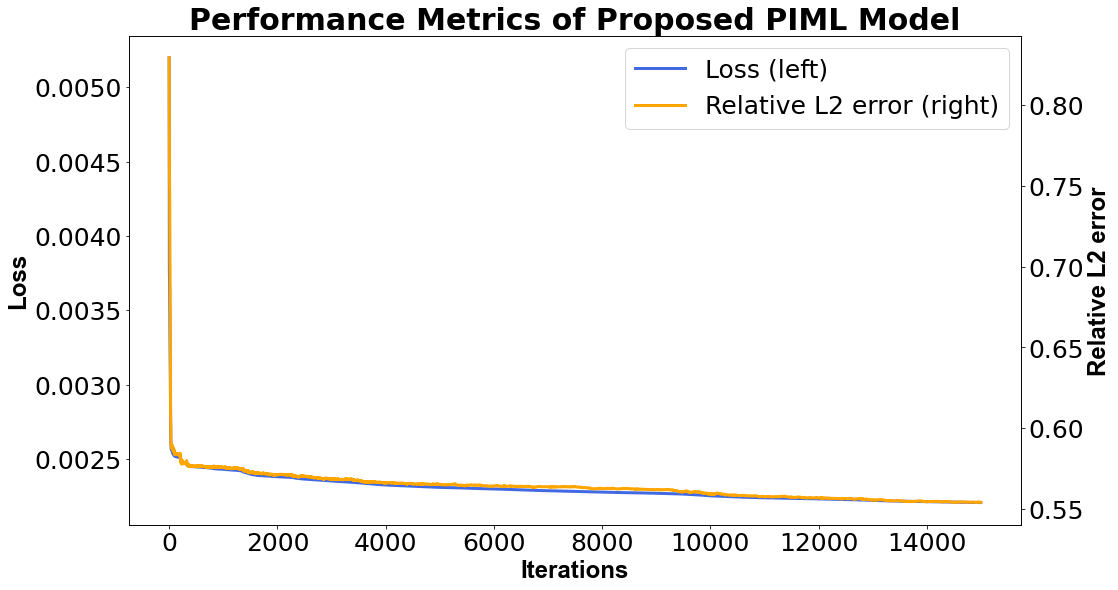

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.019848332653537776
MSE =  0.002695319037460234
RMSE =  0.05191646210461797
L2 relative error = 0.5030604191456114
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

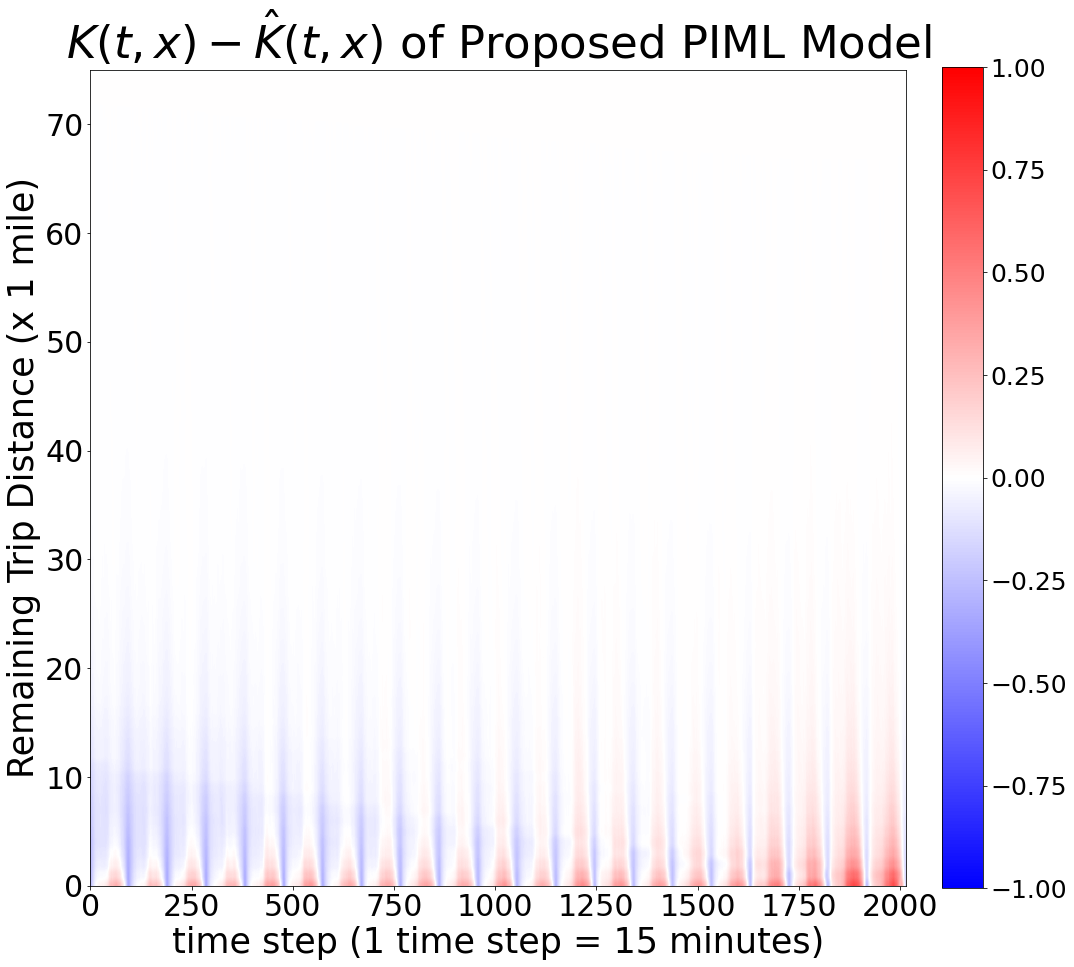

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

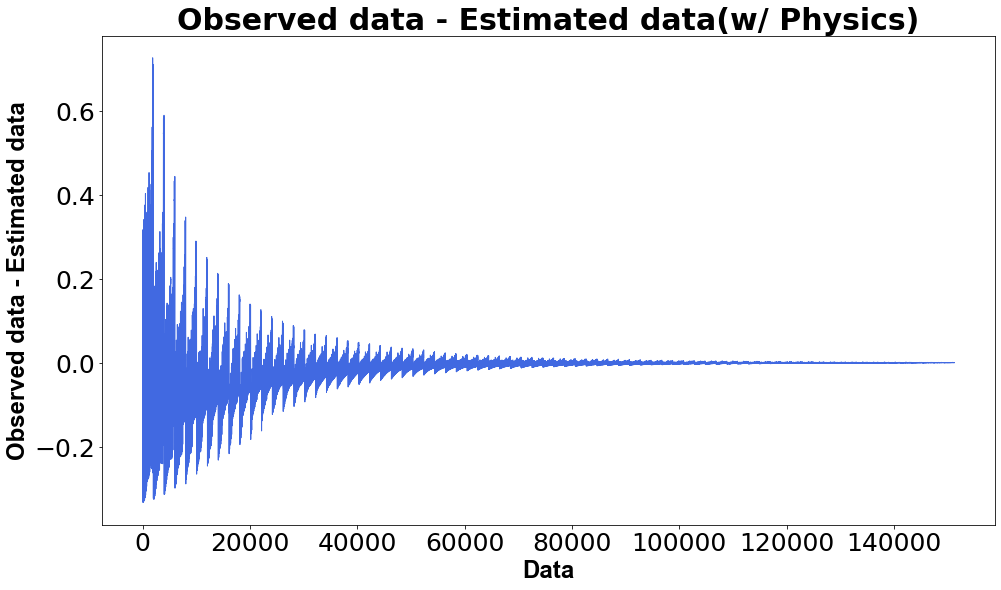

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

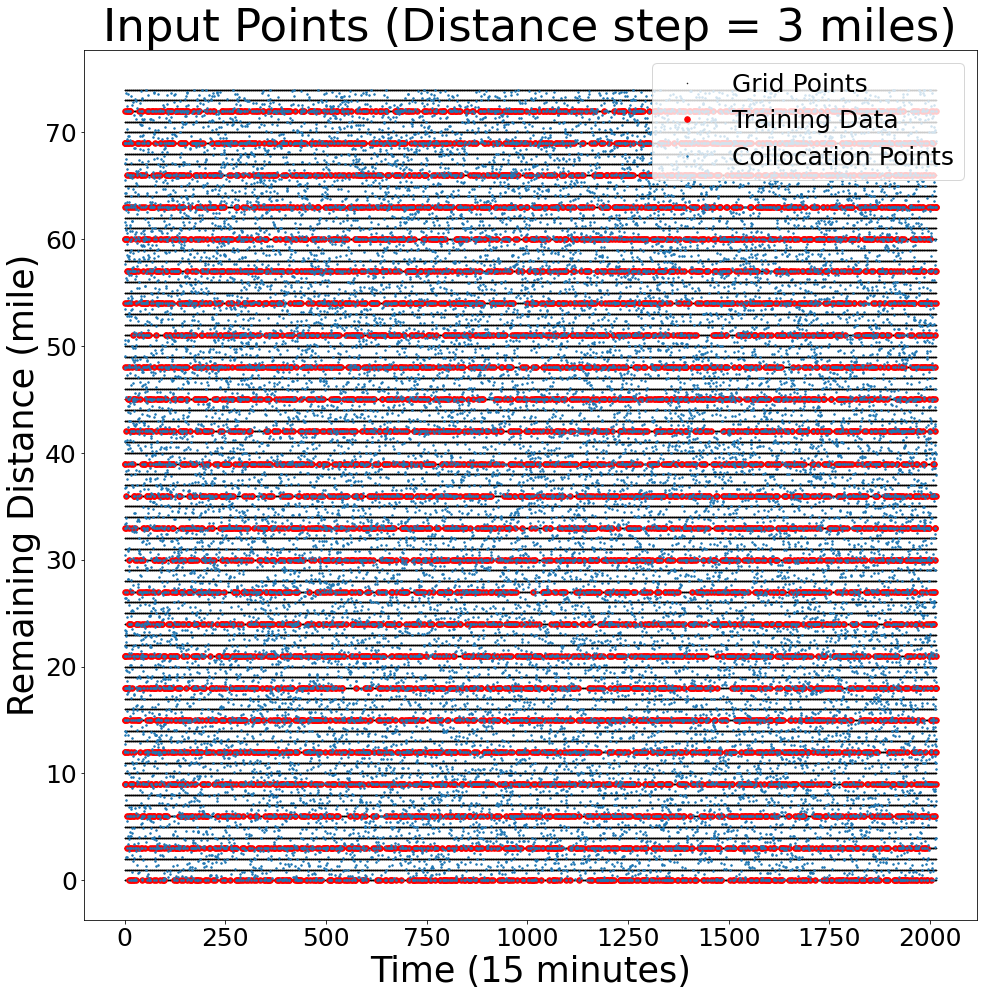

In [21]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 3 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()